### Spectrum Equation
$$
R(O^-, H)_{(\lambda)} = \frac{bb_{(\lambda)}}{2 K_{(\lambda)}} + \left( R_{b(\lambda)} - \frac{bb_{(\lambda)}}{2 K_{(\lambda)}}\right) e^{-2K_{(\lambda)} H}
$$

Where:
 - $R(O^-, H)$ is the reflectance below the water  (i.e. glint corrected)
 - $bb_{(\lambda)}$ is the backscatter coefficient
 - $K_{(\lambda)}$ is the attenuation coefficient
 - $R_{b(\lambda)}$ is the bottom reflectance

### Glint Correction
 - Subtract the infrared intensity band from the entire spectrum

### Task: How to accurately retrieve the bottom reflectance from the spectrum?

### Extra to dos:
- ~~Estimate wavelength-dependent sensor noise (fit tight spline, look at residuals)~~
    - Done with splines, odd results.
    - Look into other methods of noise estimation
- Interrogate spectral angle correlations
- For representative K and bb values, investigate at what depths the key wavelengths (showing maximum distinction between endmembers) disappear
- Simulation: sensitivity analysis of ability to retrieve (starting simple) modelled Rb e.g. with addition of noise 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# plotting
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import seaborn as sns

# stats/fitting
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.decomposition import PCA
import multiprocess as mp
# import multiprocessing as mp
from functools import partial

# custom
from reflectance import spectrum_utils, plotting
AOP_model = spectrum_utils.load_aop_model(aop_group_num=1)

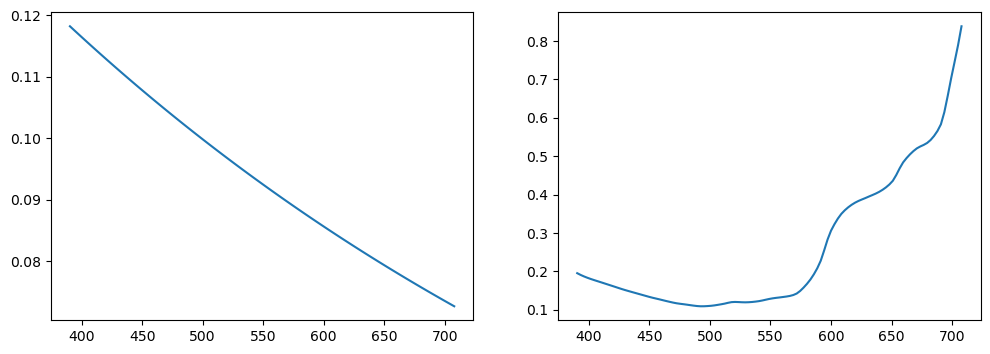

In [3]:
# AOP model is model for function with wavelength of bb and Kd
wv = AOP_model.index
# visualise models for bb and Kd
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].plot(wv, AOP_model.loc[wv].bb_m + AOP_model.loc[wv].bb_c, label="bb model, Group 1")
ax[1].plot(wv, AOP_model.loc[wv].Kd_m + AOP_model.loc[wv].Kd_c, label="Kd model, Group 1");

In [4]:
# benthic counts data
validation_data = pd.read_csv('data/CORAL_validation_data.csv')
# spectral data (PRISM-measured reflectance from nearby pixels)
spectra_raw = pd.read_csv('data/CORAL_validation_spectra.csv')
spectra_raw.columns = spectra_raw.columns.astype(float)

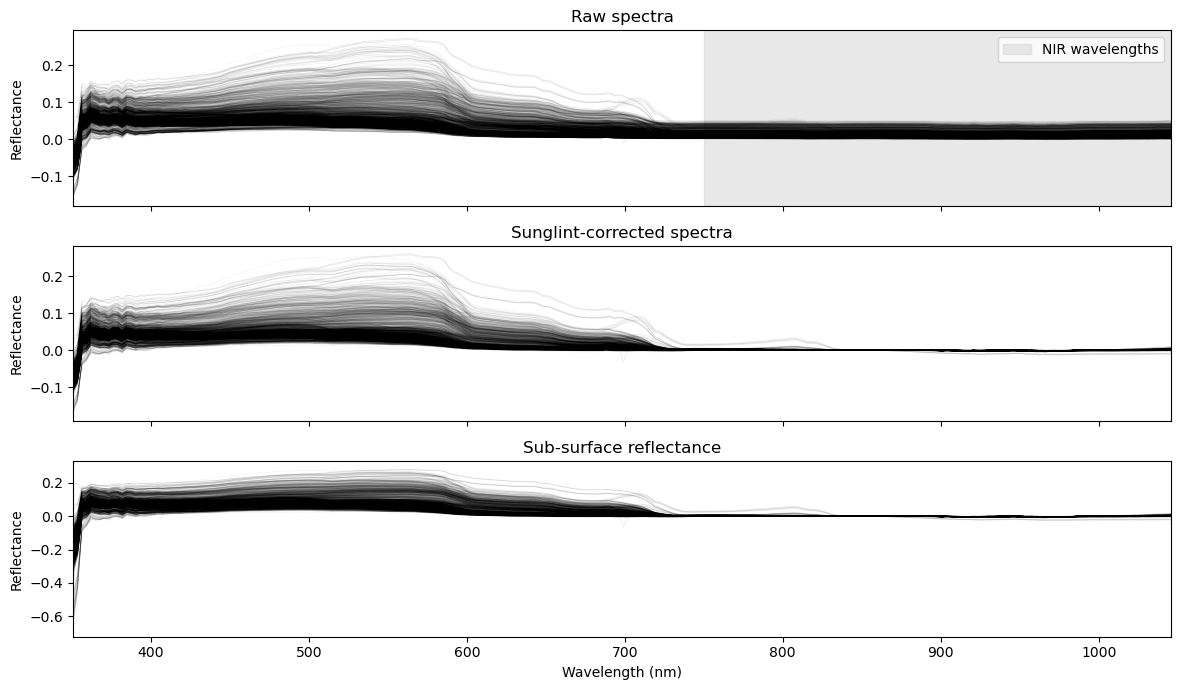

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

NIR_wvs = (750, 1100)

ax[0].plot(spectra_raw.columns, spectra_raw.values.T, color=(0,0,0,0.05), lw=0.5);
# shade NIR waveband: (https://www.lidsen.com/journals/aeer/aeer-02-03-017)
ax[0].axvspan(min(NIR_wvs), max(spectra_raw.columns) if max(spectra_raw.columns) < max(NIR_wvs) else max(spectra_raw.columns), color='lightgrey', alpha=0.5, zorder=-2, label="NIR wavelengths")
ax[0].set_title("Raw spectra")
ax[0].legend()

# sun glint correction - subtract values between 750 and 1100 (NIR) from rest of data
ind = (spectra_raw.columns > 750) & (spectra_raw.columns < 1100)
spectra_deglinted = spectra_raw.subtract(spectra_raw.loc[:, ind].mean(axis=1), axis=0)

# calculate sub-surface reflectance (from Lee et al. 1998)
spectra_corrected = spectra_deglinted / (0.518 + 1.562 * spectra_deglinted)

ax[1].plot(spectra_deglinted.columns, spectra_deglinted.values.T, color=(0,0,0,0.05), lw=0.5);
ax[1].set_title("Sunglint-corrected spectra")

# plot corrected spectra
ax[2].plot(spectra_corrected.columns, spectra_corrected.values.T, color=(0,0,0,0.05), lw=0.5);
ax[2].set_title("Sub-surface reflectance")

for a in ax:
    a.set_xlim(spectra_corrected.columns.min(), spectra_corrected.columns.max())
    a.set_ylabel("Reflectance")
ax[2].set_xlabel("Wavelength (nm)")
    
plt.tight_layout()

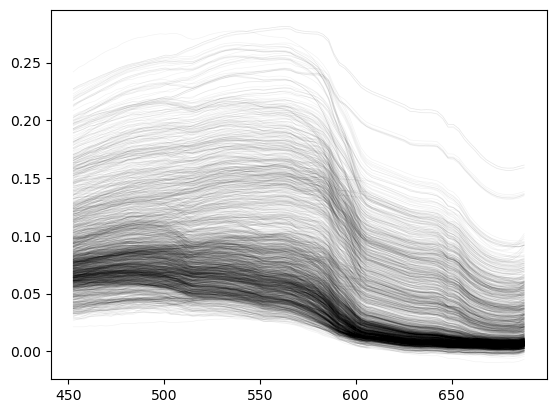

In [6]:
# clip spectra to AOP valid range (instrument calibration limitations)
ind = (spectra_corrected.columns > 450) & (spectra_corrected.columns < 690)
prism_spectra = spectra_corrected.loc[:, ind]
plt.plot(prism_spectra.columns, prism_spectra.values.T, color=(0,0,0,0.05), lw=0.5);

### Observations
- R2 does a pretty terrible job of describing goodness of fit
### TODO
- Is this covariance matrix useful?
- Some spectra e.g. i=888 are weird and jagged: is there a way to quantify and investigate these?

# Average Component-based Rb model

## Visualising spectra

In [7]:
f = 'reflectance/resources/spectral_library_clean_v3_PRISM_wavebands.csv'
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)
# clip to valid wv range
df = df.loc[:, prism_spectra.columns]

cats = df.index.unique()  # get categories

end_members = {}
for cat in cats:
    ind = df.index == cat
    # select all spectra in category and calculate mean spectrum
    end_members[cat] = df.loc[ind].mean(axis=0)
# create array of average spectrum for each category
end_member_array = np.array([spectrum.values for spectrum in end_members.values()])

print('number of endmembers: ', len(end_member_array))
df.head()

number of endmembers:  11


452.642775  455.475056  458.307394  461.139788  \
wavelength                                                                 
algae_crustose_coralline    0.024956    0.025307    0.025593    0.025889   
algae_crustose_coralline    0.026762    0.027168    0.027538    0.027888   
algae_crustose_coralline    0.047371    0.048106    0.048553    0.048921   
algae_crustose_coralline    0.021885    0.022216    0.022436    0.022594   
algae_crustose_coralline    0.015678    0.015880    0.016051    0.016234   

                          463.972238  466.804744  469.637306  472.469925  \
wavelength                                                                 
algae_crustose_coralline    0.026249    0.026669    0.027123    0.027563   
algae_crustose_coralline    0.028217    0.028544    0.028896    0.029274   
algae_crustose_coralline    0.049452    0.050271    0.051370    0.052624   
algae_crustose_coralline    0.022775    0.023056    0.023476    0.024008   
algae_crustose_coralline    0.016447    0.016688    0.016966    0.017266   

                          475.302600  478.135331  ...  662.383497  665.219940  \
wavelength                                        ...                           
algae_crustose_coralline    0.027943    0.028233  ...    0.049980    0.046018   
algae_crustose_coralline    0.029645    0.029975  ...    0.050251    0.045835   
algae_crustose_coralline    0.053837    0.054839  ...    0.109760    0.101359   
algae_crustose_coralline    0.024575    0.025109  ...    0.056447    0.052379   
algae_crustose_coralline    0.017577    0.017888  ...    0.037927    0.034945   

                          668.056439  670.892995  673.729607  676.566275  \
wavelength                                                                 
algae_crustose_coralline    0.042525    0.039782    0.037933    0.037039   
algae_crustose_coralline    0.041945    0.038914    0.036896    0.035915   
algae_crustose_coralline    0.093901    0.088094    0.084302    0.082658   
algae_crustose_coralline    0.048849    0.046283    0.044905    0.044773   
algae_crustose_coralline    0.032384    0.030518    0.029474    0.029246   

                          679.402999  682.239779  685.076616  687.913509  
wavelength                                                                
algae_crustose_coralline    0.037104    0.038188    0.040405    0.043873  
algae_crustose_coralline    0.035968    0.037139    0.039624    0.043634  
algae_crustose_coralline    0.083223    0.086160    0.091666    0.099919  
algae_crustose_coralline    0.045785    0.047909    0.051187    0.055683  
algae_crustose_coralline    0.029774    0.031100    0.033334    0.036624  

[5 rows x 84 columns]

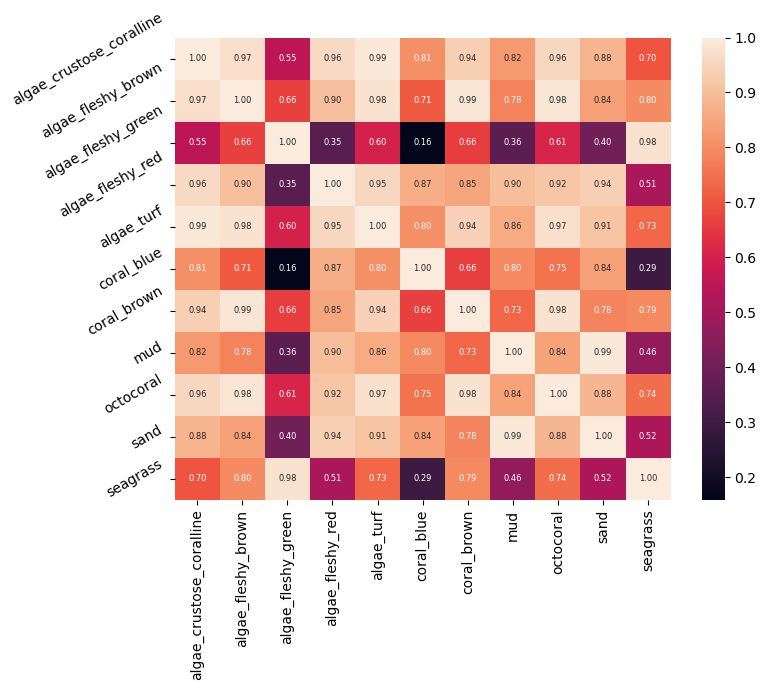

In [8]:
# visualise correlation between end-members
plt.figure(figsize=[8,6])
ax = sns.heatmap(np.corrcoef(end_member_array), annot=True, fmt='.2f', annot_kws={'fontsize':6})
ax.set_xticklabels(cats, rotation=90)
ax.set_yticklabels(cats, rotation=30);

In [9]:
# plot exponential decay function as function of wavelength and depth: sea at which depths peaks become invisible
# spectral angle may help with optimisation tolerance

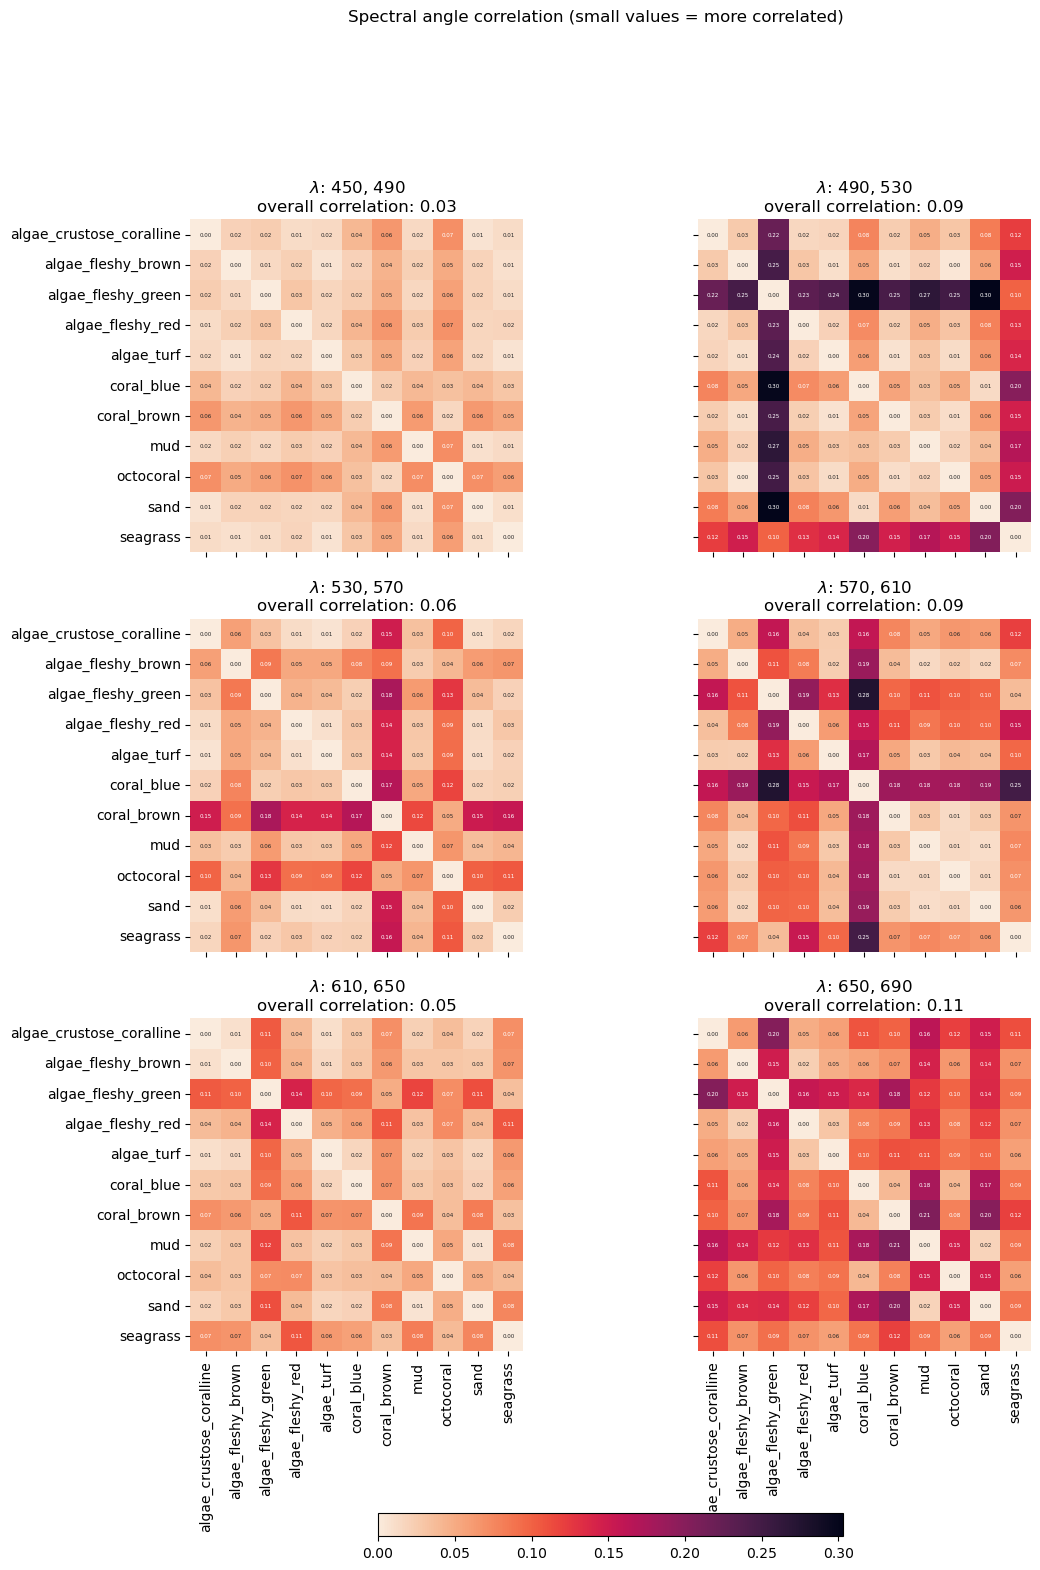

In [10]:
corr_type = "spectral_angle"

def compute_correlation(end_member_array: np.ndarray, corr_type: str = 'pearson') -> np.ndarray:
    """
    Compute correlation matrix between end-members.
    """
    if corr_type == 'pearson':
        return np.corrcoef(end_member_array)
    elif corr_type == "spectral_angle":
        return spectrum_utils.spectral_angle_correlation_matrix(end_member_array)
    else:
        raise ValueError(f"Invalid corr_type. Must be one of 'pearson' or 'spectral_angle'. Received: {corr_type}")

# Generate wavelength kernel pairs
min_wv, max_wv = 450, 670
kernel_width = 40
kernel_displacement = 40
wv_pairs = [(wv, wv+kernel_width) for wv in np.arange(min_wv, max_wv, kernel_displacement)]

corr_matrices = [compute_correlation(end_member_array[:, (prism_spectra.columns > min(wvs)) & (prism_spectra.columns < max(wvs))], corr_type=corr_type) for wvs in wv_pairs]
min_corr = min(matrix.min() for matrix in corr_matrices)
max_corr = max(matrix.max() for matrix in corr_matrices)

all_kernel_corrs = {}
num_rows = int(np.ceil(len(wv_pairs)/2))
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 7*num_rows), sharex=True, sharey=True)

if corr_type == "spectral_angle":
    cmap = "rocket_r"
    plt.suptitle("Spectral angle correlation (small values = more correlated)")
else:
    cmap = "rocket"

for i, (wvs, corr_matrix) in enumerate(zip(wv_pairs, corr_matrices)):
    ax = sns.heatmap(corr_matrix, annot=True, fmt='.2f',
                     annot_kws={'fontsize':4}, ax=axes.flatten()[i],
                     vmin=min_corr, vmax=max_corr, cbar_kws={'shrink': 0.8}, cbar=False, cmap=cmap)  # Use global min/max for vmin/vmax
    
    ax.set_xticklabels(cats, rotation=90)
    ax.set_yticklabels(cats, rotation=0)
    
    # calculate the mean of the upper triangle of the correlation matrix (excluding diagonal)
    kernel_corr = corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)].mean()
    # all_kernel_corrs[wvs] = kernel_corr
    ax.set_title(f"$\\lambda$: {min(wvs)}, {max(wvs)}\noverall correlation: {kernel_corr:.2f}")
    ax.set_aspect("equal")
    
# remove any empty axes
for i in range(len(wv_pairs), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

fig.colorbar(ax.collections[0], ax=axes, orientation='horizontal', fraction=0.2, pad=0.1, shrink=0.5, cmap=cmap)

plt.show()

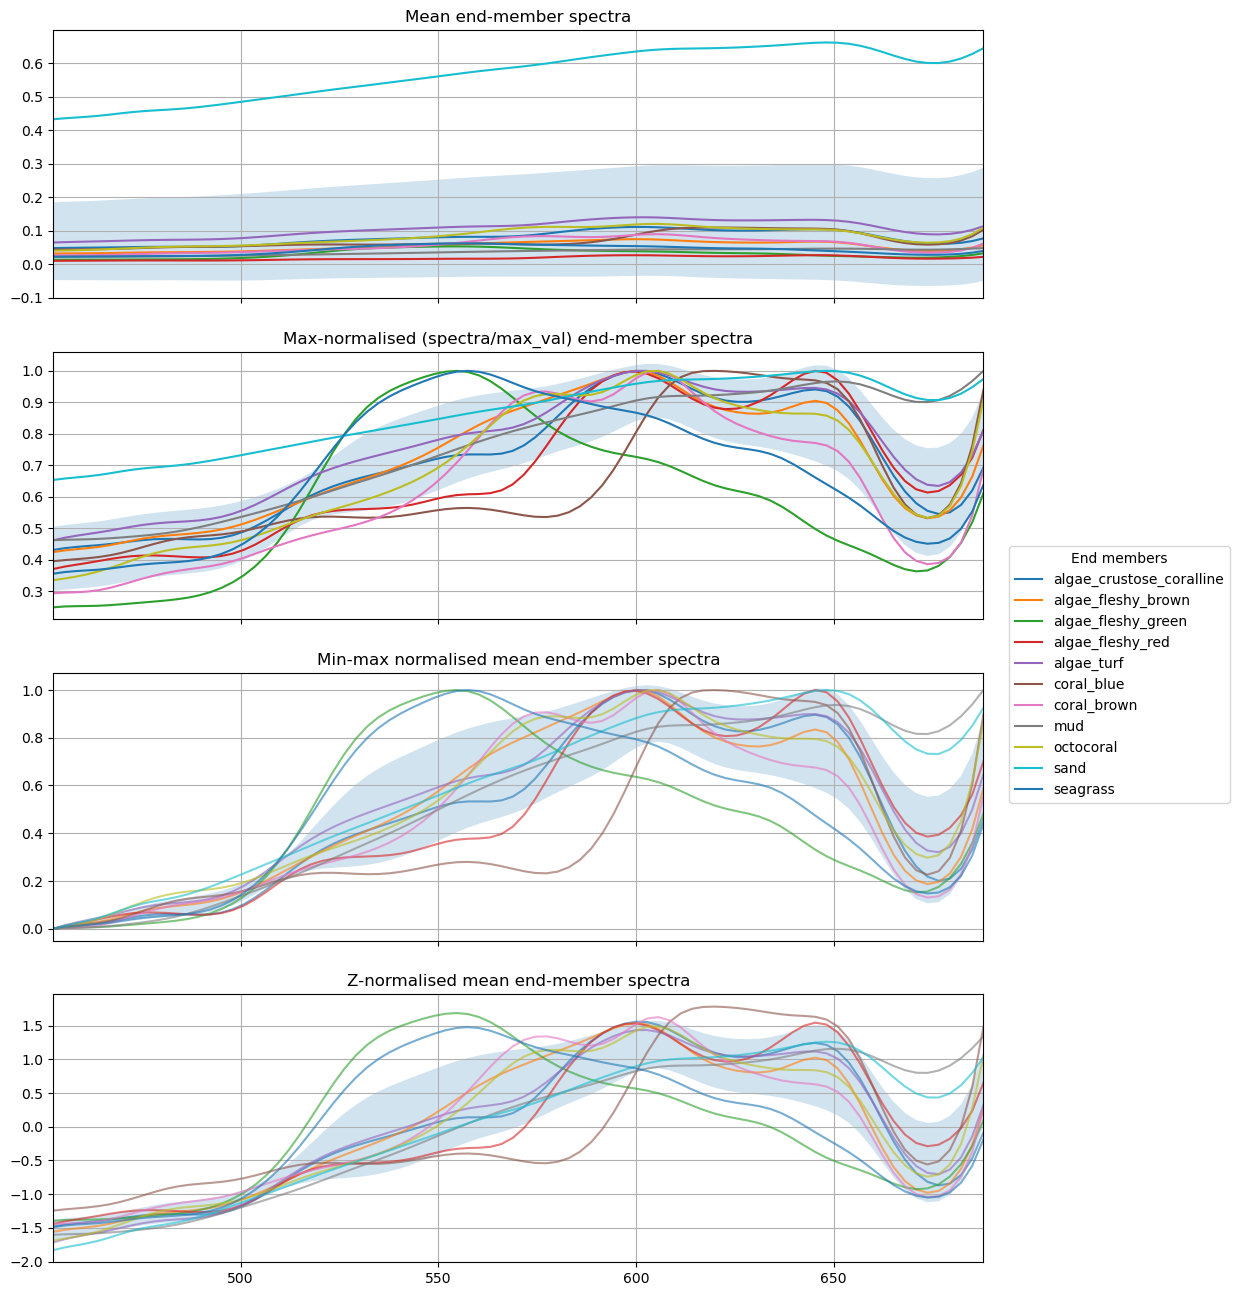

In [11]:
# plot end_members with different scaling
endmembers_max = {cat: spectrum / spectrum.max() for cat, spectrum in end_members.items()}
endmembers_minmax = {cat: (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min()) for cat, spectrum in end_members.items()}
endmembers_znorm = {cat: (spectrum - spectrum.mean(axis=0)) / spectrum.std(axis=0) for cat, spectrum in end_members.items()}
    
fig, ax = plt.subplots(4, 1, figsize=[12,16], sharex=True)
for cat, spectrum in end_members.items():
    ax[0].plot(spectrum.index, spectrum, label=cat)
    ax[1].plot(spectrum.index, endmembers_max[cat], label=cat)
    ax[2].plot(spectrum.index, endmembers_minmax[cat], label=cat, alpha=0.6)
    ax[3].plot(spectrum.index, endmembers_znorm[cat], label=cat, alpha=0.6)
    
# visualise spread of spectra
end_members_maxscale_array = np.array([spectrum.values for spectrum in endmembers_max.values()])
end_members_minmaxscale_array = np.array([spectrum.values for spectrum in endmembers_minmax.values()])
end_members_znormscale_array = np.array([spectrum.values for spectrum in endmembers_znorm.values()])

for i, end_member_spectra in enumerate([end_member_array, end_members_maxscale_array, end_members_minmaxscale_array, end_members_znormscale_array]):
    spectra_std = np.std(end_member_spectra, axis=0)
    spectra_mean = np.mean(end_member_spectra, axis=0)
    ax[i].fill_between(spectrum.index, spectra_mean - spectra_std, spectra_mean + spectra_std, alpha=0.2)
    
ax[0].set_xlim(min(spectrum.index), max(spectrum.index))

ax[0].set_title("Mean end-member spectra");
ax[1].set_title("Max-normalised (spectra/max_val) end-member spectra");
ax[2].set_title("Min-max normalised mean end-member spectra");
ax[3].set_title("Z-normalised mean end-member spectra");

ax[1].legend(bbox_to_anchor=(1.02, 0.3), title="End members")
[a.grid() for a in ax];

# remove spectrum variable
del spectrum

In [12]:
# # Generate wavelength kernel pairs
# min_wv, max_wv = 450, 670
# kernel_width = 5
# kernel_displacement = 5
# wv_pairs = [(wv, wv+kernel_width) for wv in np.arange(min_wv, max_wv, kernel_displacement)]


# fig, ax = plt.subplots(4, 1, figsize=[12,16], sharex=True)
# for cat, spectrum in end_members.items():
#     ax[0].plot(spectrum.index, spectrum, label=cat)
#     ax[1].plot(spectrum.index, endmembers_max[cat], label=cat, alpha=0.6)
#     ax[2].plot(spectrum.index, endmembers_minmax[cat], label=cat, alpha=0.6)
#     ax[3].plot(spectrum.index, endmembers_znorm[cat], label=cat, alpha=0.6)
    
# ax[0].set_xlim(min(spectrum.index), max(spectrum.index))

# ax[1].legend(bbox_to_anchor=(1.02, 0.3), title="End members")
# # [a.grid(which='minor') for a in ax];
# for a in ax:
#     a.xaxis.set_major_locator(plt.MultipleLocator(10))
#     a.grid('major', axis='x')


# spectra_kernel_corrs = {}
# # for each type of spectral normalisation method
# for i, endmembers in enumerate([end_member_array, end_members_maxscale_array, end_members_minmaxscale_array, end_members_znormscale_array]):
#     # calculate correlation matrices between end-members
#     corr_matrices = [compute_correlation(endmembers[:, (prism_spectra.columns > min(wvs)) & (prism_spectra.columns < max(wvs))], corr_type=corr_type) for wvs in wv_pairs]
#     # calculate mean correlation for each kernel pair
#     kernel_corrs = [corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)].mean() for corr_matrix in corr_matrices]
#     spectra_kernel_corrs[i] = kernel_corrs
    
#     ax[i].set_title(f"Mean end-member spectra\nMean correlation: {np.mean(kernel_corrs):.5f}")
#     ax[i].set_title(f"Max-normalised (spectra/max_val) end-member spectra\nMean correlation: {np.mean(kernel_corrs):.5f}")
#     ax[i].set_title(f"Min-max normalised mean end-member spectra\nMean correlation: {np.mean(kernel_corrs):.5f}")
#     ax[i].set_title(f"Z-normalised mean end-member spectra\nMean correlation: {np.mean(kernel_corrs):.5f}")


# min_corr = min([value for sublist in spectra_kernel_corrs.values() for value in sublist])
# max_corr = max([value for sublist in spectra_kernel_corrs.values() for value in sublist])

# spectra_kernel_corrs_norms = {k: (v - min_corr) / (max_corr - min_corr) for k, v in (spectra_kernel_corrs.items())}
# spectra_kernel_corrs_norms

# for i, endmembers in enumerate([end_member_array, end_members_maxscale_array, end_members_minmaxscale_array, end_members_znormscale_array]):    # min_corr = min(all_kernel_corrs.values())
#     for j, wvs in enumerate(wv_pairs):
#         endmember_corrs = spectra_kernel_corrs_norms[i]
#         if corr_type == "spectral_angle":
#             alpha = (endmember_corrs[j])
#         else:
#             alpha = 0.3*(1 - endmember_corrs[j])
#         ax[i].axvspan(wvs[0], wvs[1], color=(0,0,0,alpha))
        
# if corr_type == "spectral_angle":
#     plt.suptitle("Spectral angle correlation (small values = more correlated)")
# # plot a colourbar of correlation values
# sm = plt.cm.ScalarMappable(cmap="grey", norm=plt.Normalize(vmin=min_corr, vmax=max_corr))
# plt.colorbar(sm, ax=ax, orientation='horizontal', label="Correlation value", fraction=0.2, pad=0.02, shrink=0.5, alpha=1)
# # plt.tight_layout()

### Spectral angle

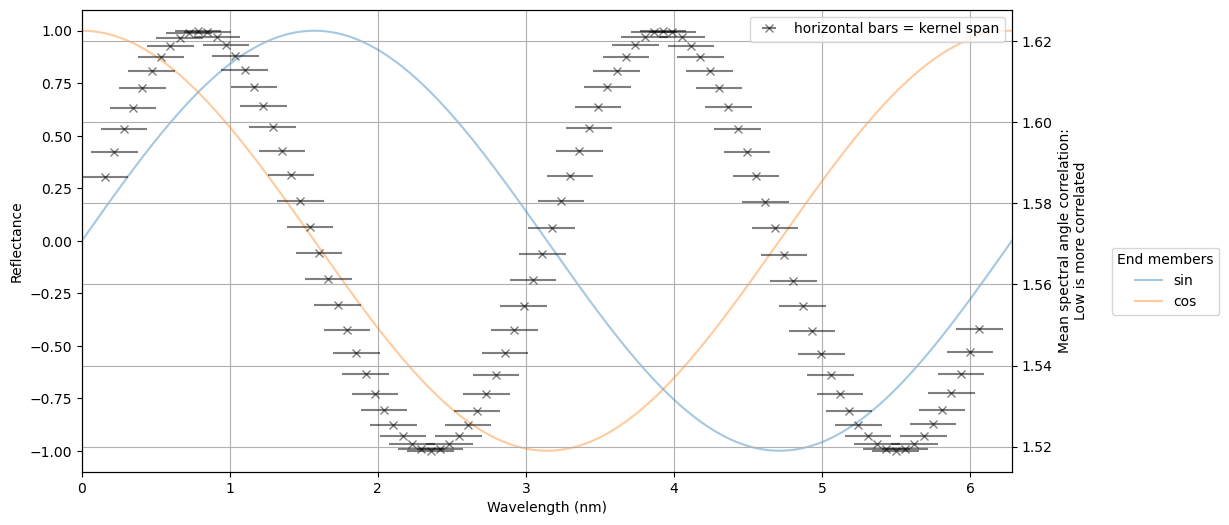

In [13]:
# checking that spectral angle calculation/plot is correct
xs = np.linspace(0, 2*np.pi, 1000)

kernel_width = 0.1*np.pi
kernel_displacement = 0.02*np.pi

curve_dict = {
    'sin': pd.Series(np.sin(xs), index=xs),
    # 'sin2': pd.Series(10*np.sin(xs), index=xs),
    'cos': pd.Series(np.cos(xs), index=xs),
}

plotting.plot_rolling_spectral_correlation(curve_dict, kernel_width, kernel_displacement)
wv_pairs, mean_corrs = spectrum_utils.calc_rolling_spectral_angle(xs, np.array([curve_dict[k].values for k in curve_dict.keys()]), kernel_width, kernel_displacement)


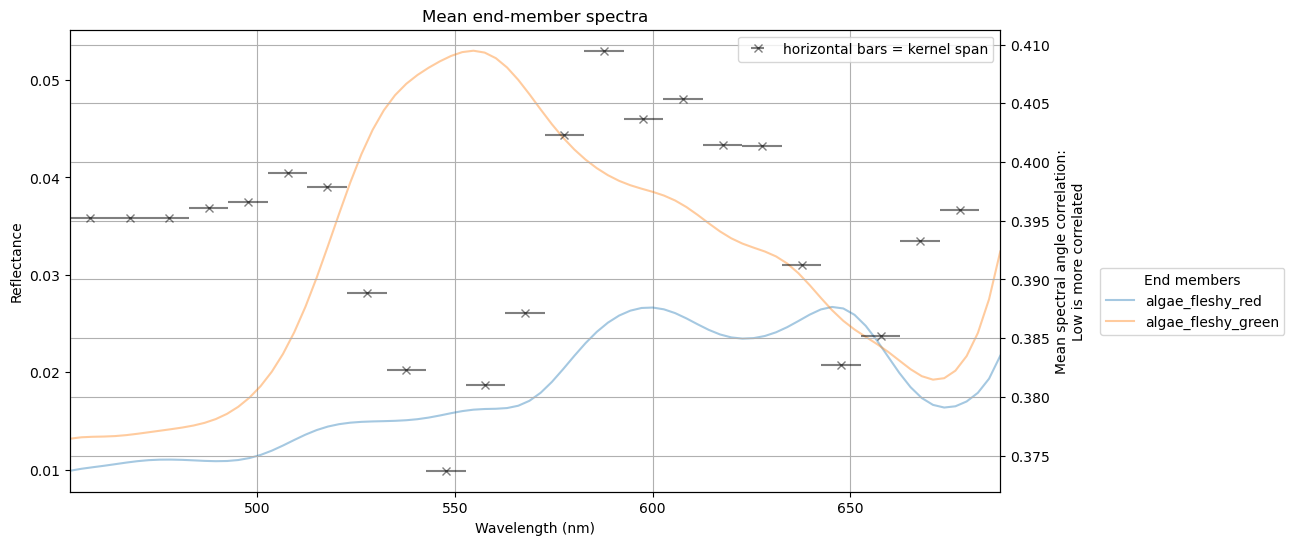

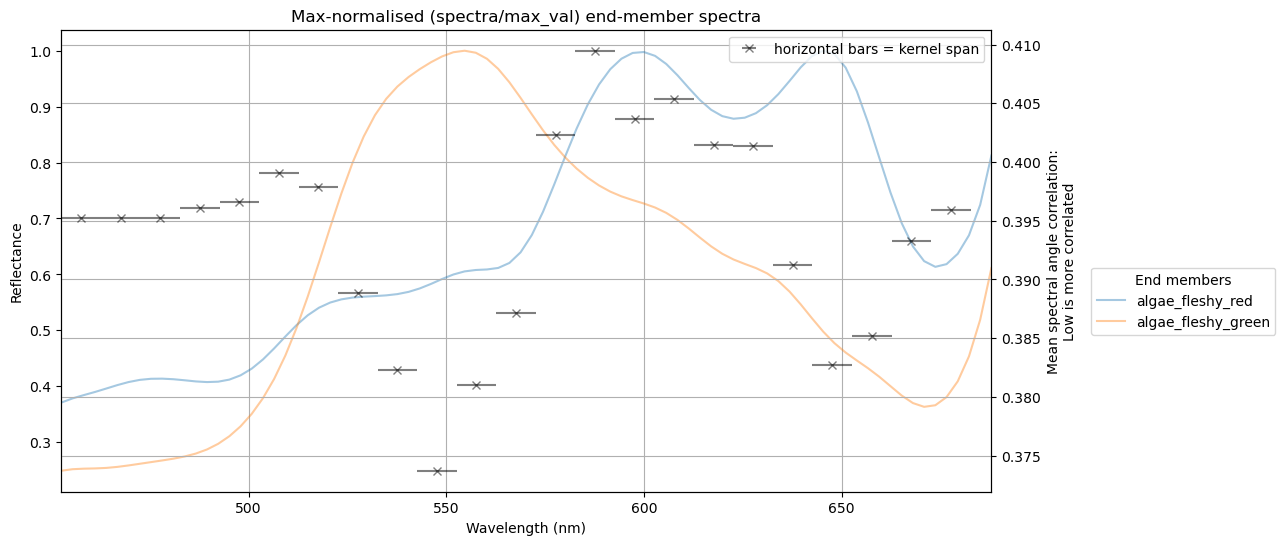

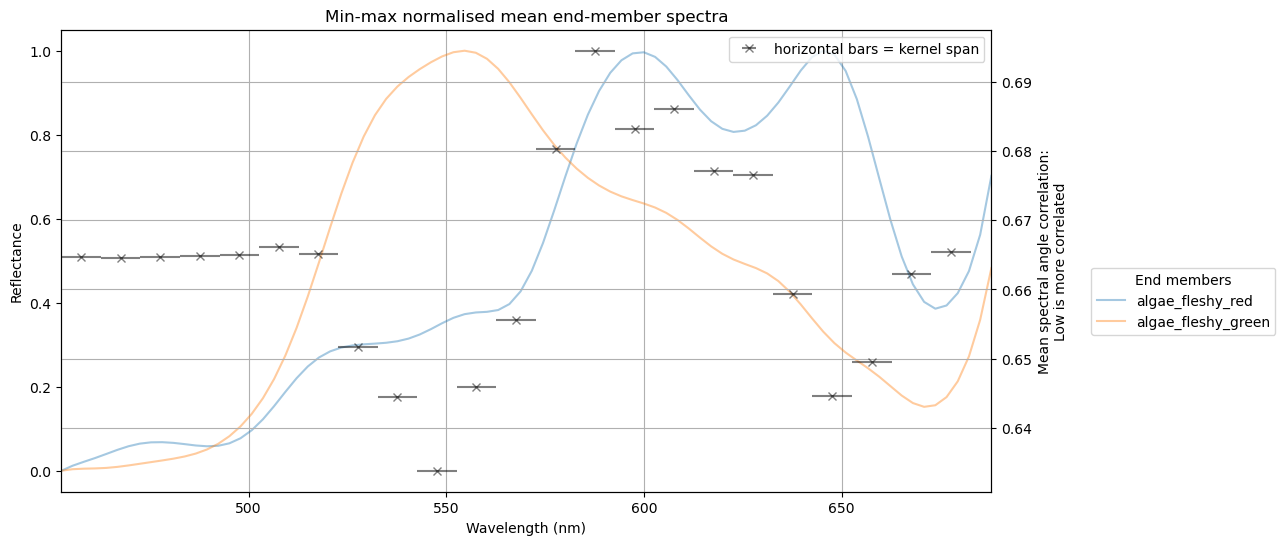

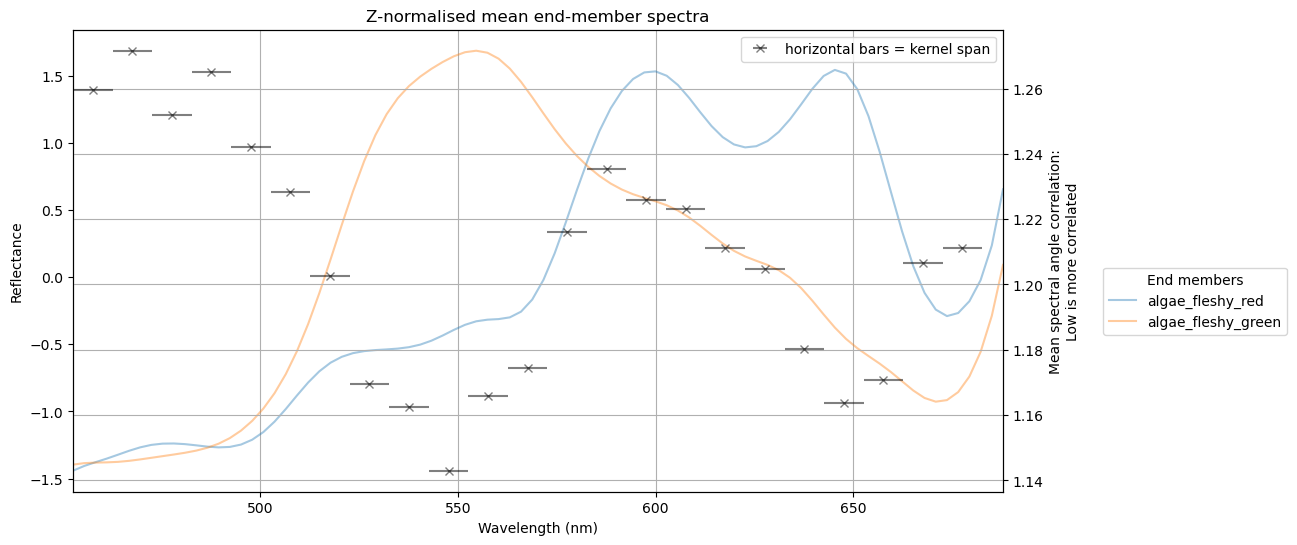

In [15]:
# plot characteristics
kernel_width = 10
kernel_displacement = 10    # can be adjusted to return a rolling average
wv_pairs = [(wv, wv+kernel_width) for wv in np.arange(min_wv, max_wv, kernel_displacement)]

end_member_titles = ["Mean end-member spectra", "Max-normalised (spectra/max_val) end-member spectra", "Min-max normalised mean end-member spectra", "Z-normalised mean end-member spectra"]
for i, end_members in enumerate([end_members, endmembers_max, endmembers_minmax, endmembers_znorm]):
    subset_end_members = {key: end_members[key] for key in ["algae_fleshy_red", "algae_fleshy_green"]}
    # subset_end_members = {
    #     "algae_fleshy_red": end_members["algae_fleshy_red"],
    #     "algae_fleshy_red_2": end_members["algae_fleshy_red"]+1,
    #     }
    plotting.plot_rolling_spectral_correlation(subset_end_members, kernel_width, kernel_displacement)
    plt.title(end_member_titles[i]);

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_65169/136466287.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, fontsize=8)


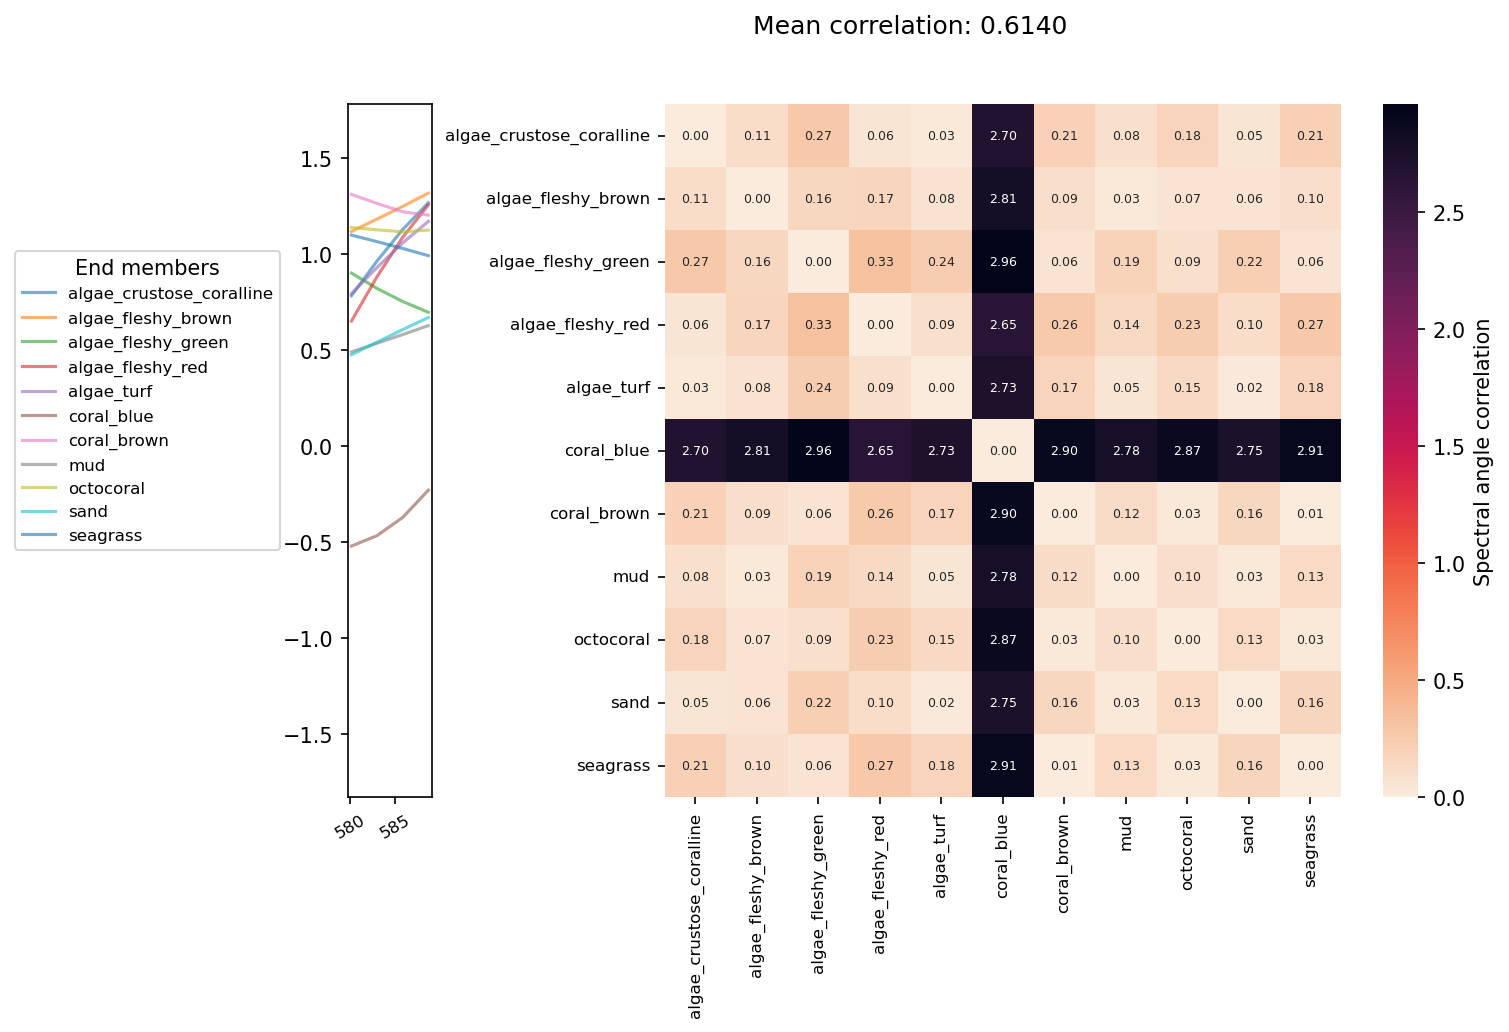

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10, 6), dpi=150, 
                       width_ratios=[0.1,1]
                       )

wv_range = (580, 590)
ids = (prism_spectra.columns > min(wv_range)) & (prism_spectra.columns < max(wv_range))
wvs = prism_spectra.columns[ids]
for endmember in range(end_members_znormscale_array.shape[0]):
    ax[0].plot(wvs, end_members_znormscale_array[endmember, ids], label=cats[endmember], alpha=0.6)
    
corr_mat = spectrum_utils.spectral_angle_correlation_matrix(end_members_znormscale_array[:, ids])
sns.heatmap(corr_mat, annot=True, fmt='.2f', annot_kws={'fontsize':6}, ax=ax[1], cmap='rocket_r', cbar_kws={'orientation': "vertical"})
# calculate mean of corr_mat
mean_corr = corr_mat[np.triu_indices(corr_mat.shape[0], k=1)].mean()

# formatting
ax[0].legend(title="End members", fontsize=8, bbox_to_anchor=(-.7, 0.8))
ax[0].set_ylim(end_members_znormscale_array.min(), end_members_znormscale_array.max())  # set y-axis limits to min/max of end-members to compare to whole spectrum
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, fontsize=8)
ax[1].collections[0].colorbar.set_label("Spectral angle correlation")
ax[1].set_xticklabels(cats, rotation=90, fontsize=8)
ax[1].set_yticklabels(cats, rotation=0, fontsize=8)
plt.suptitle(f"Mean correlation: {mean_corr:.4f}")
plt.subplots_adjust(wspace=0.5);

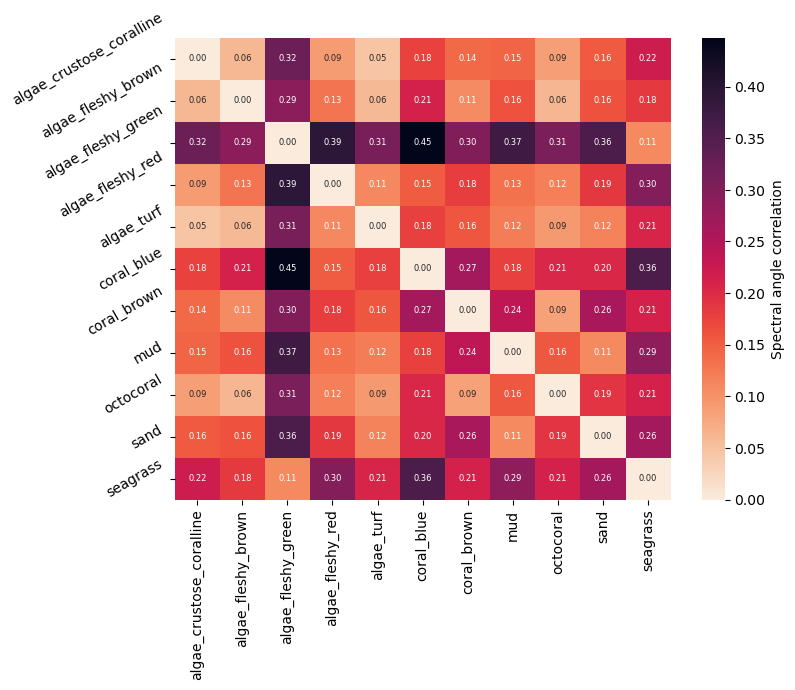

In [17]:
# visualise correlation between end-members
plt.figure(figsize=[8,6])
ax = sns.heatmap(spectrum_utils.spectral_angle_correlation_matrix(end_member_array), annot=True, fmt='.2f', annot_kws={'fontsize':6}, cmap='rocket_r')
ax.collections[0].colorbar.set_label("Spectral angle correlation")
ax.set_xticklabels(cats, rotation=90)
ax.set_yticklabels(cats, rotation=30);

## Noise estimation

In [18]:
spectra_corrected

350.718103   353.548360   356.378673   359.209042   362.039467   \
0       -0.088207    -0.040560     0.143655     0.137899     0.152775   
1       -0.103556    -0.042124     0.136809     0.146524     0.161334   
2       -0.091405    -0.042473     0.128363     0.137454     0.157239   
3       -0.092976    -0.044062     0.139562     0.136712     0.151321   
4       -0.085700    -0.038586     0.145053     0.138974     0.167120   
...           ...          ...          ...          ...          ...   
1933    -0.164327    -0.103457     0.060112     0.075390     0.098312   
1934    -0.157861    -0.100504     0.066598     0.077990     0.093763   
1935    -0.139104    -0.087548     0.076950     0.078143     0.095309   
1936    -0.144804    -0.090247     0.072009     0.078622     0.097984   
1937    -0.148431    -0.085116     0.069498     0.080776     0.097369   

      364.869949   367.700487   370.531081   373.361731   376.192438   ...  \
0        0.158635     0.144351     0.150188     0.146312     0.155336  ...   
1        0.151524     0.147098     0.148012     0.141304     0.156534  ...   
2        0.150895     0.149538     0.150330     0.138878     0.146112  ...   
3        0.161355     0.149966     0.150192     0.144124     0.153896  ...   
4        0.156668     0.153677     0.155454     0.150873     0.154345  ...   
...           ...          ...          ...          ...          ...  ...   
1933     0.083827     0.077933     0.077933     0.071151     0.079566  ...   
1934     0.090366     0.080362     0.084320     0.074695     0.083299  ...   
1935     0.095309     0.087076     0.086354     0.077547     0.086498  ...   
1936     0.089546     0.085807     0.081577     0.075785     0.084501  ...   
1937     0.091759     0.086178     0.084001     0.074667     0.083563  ...   

      1020.218215  1023.061744  1025.905330  1028.748971  1031.592670  \
0       -0.000499    -0.000499    -0.000112    -0.000305    -0.000112   
1       -0.000722    -0.000722    -0.000142     0.001592     0.000244   
2        0.000323    -0.000063    -0.000256     0.001094     0.000323   
3       -0.001072    -0.000298    -0.000491     0.000281    -0.001266   
4       -0.000679     0.001057    -0.000486     0.000094    -0.000292   
...           ...          ...          ...          ...          ...   
1933    -0.000454     0.000511     0.001088    -0.000648     0.001088   
1934     0.000391     0.000969    -0.000574    -0.000188     0.001546   
1935     0.000590     0.000397     0.000590     0.000204     0.000782   
1936     0.000439    -0.000140     0.000632     0.000439     0.001017   
1937     0.000740     0.001510     0.000740     0.000740     0.000933   

      1034.436424  1037.280234  1040.124101  1042.968024  1045.812003  
0       -0.001467    -0.000112     0.000467     0.000852     0.001044  
1        0.001592     0.000244     0.003889     0.000630     0.000051  
2       -0.000836    -0.000063    -0.001029     0.000709     0.000131  
3        0.000667    -0.001266     0.002396    -0.002820    -0.000105  
4        0.001442    -0.001066     0.002976     0.000094     0.001826  
...           ...          ...          ...          ...          ...  
1933     0.000511     0.001473    -0.000454     0.001473     0.000511  
1934     0.000969     0.001546     0.000969     0.001354    -0.000188  
1935     0.001552     0.000975     0.000590     0.000204     0.000975  
1936     0.001594     0.001594     0.001594     0.000439     0.001978  
1937     0.000547     0.001317    -0.000031     0.001894     0.002085  

[1938 rows x 246 columns]

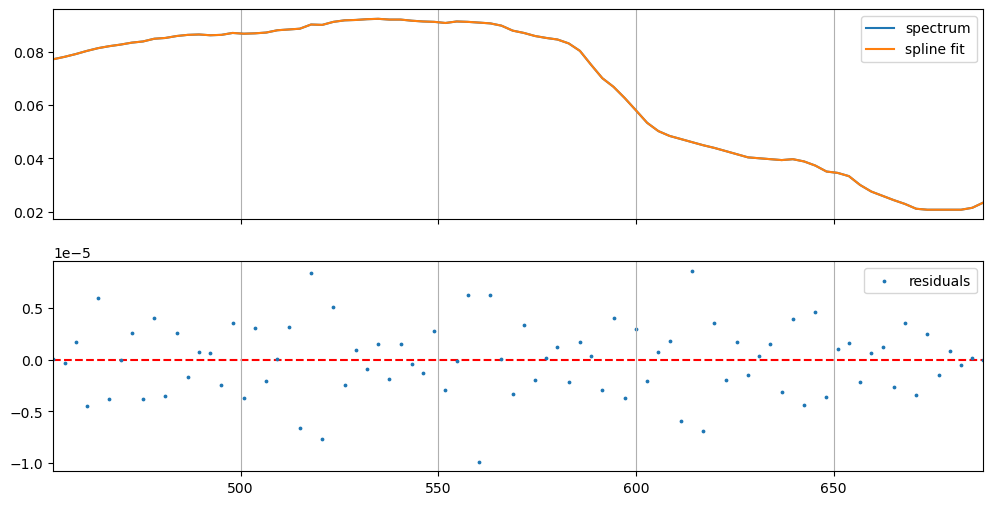

In [19]:
# example spectrum
i = 240

smoothing_factor = 1e-9
# visualise single spline
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
# plot spectrum
ax[0].plot(prism_spectra.columns, prism_spectra.values[i], label="spectrum")
# fit spline
spline = UnivariateSpline(prism_spectra.columns, prism_spectra.values[i], s=smoothing_factor)
ax[0].plot(prism_spectra.columns, spline(prism_spectra.columns), label="spline fit")

# plot residuals
residuals = prism_spectra.values[i] - spline(prism_spectra.columns)
ax[1].scatter(prism_spectra.columns, residuals, s=3, label="residuals");
ax[1].hlines(0, prism_spectra.columns.min(), prism_spectra.columns.max(), color='r', linestyle='--', zorder=-2)

for a in ax:
    a.set_xlim(prism_spectra.columns.min(), prism_spectra.columns.max())
    a.grid(axis="x")
    a.legend()

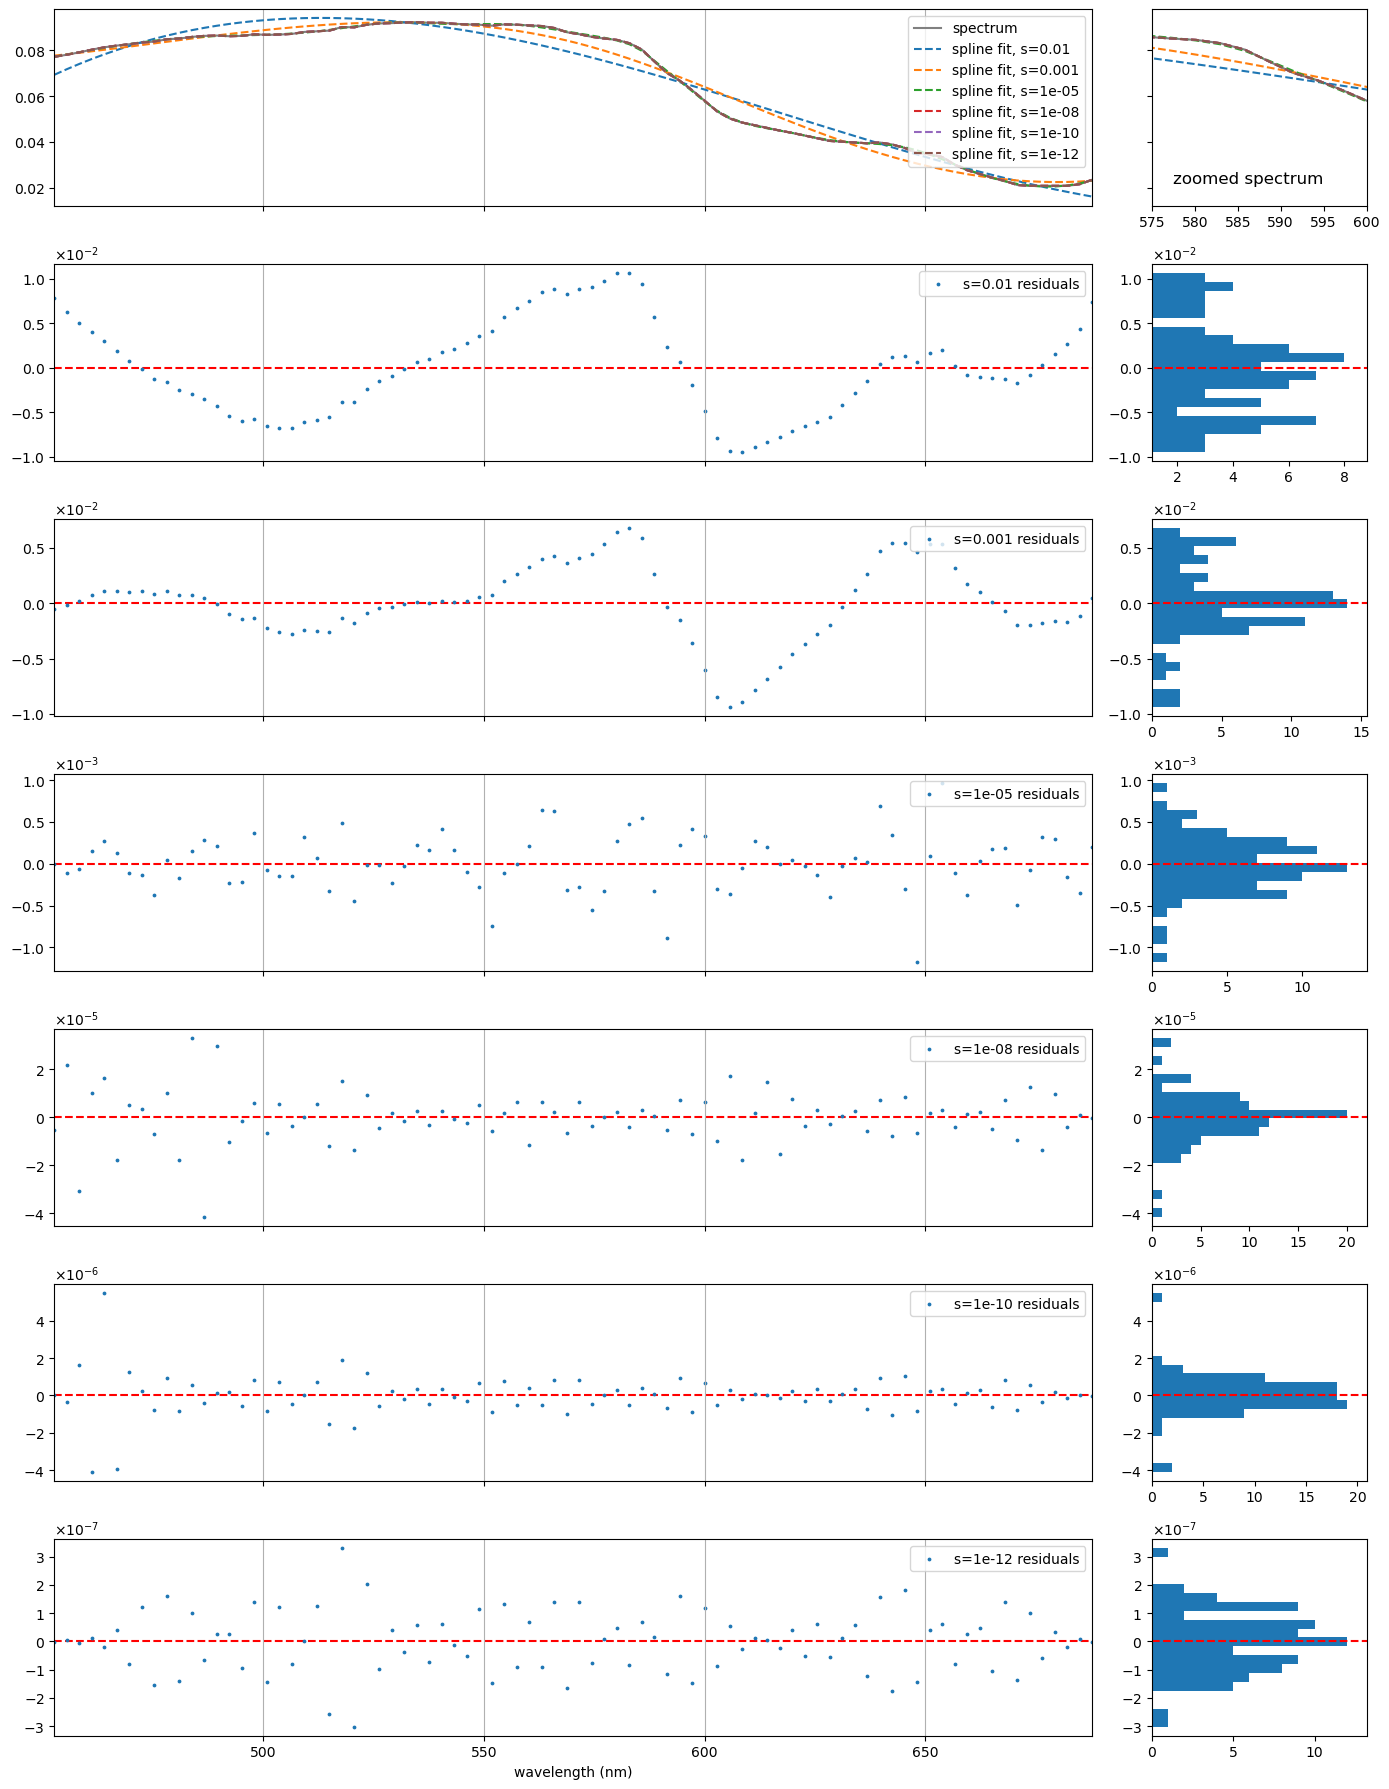

In [22]:
smoothing_factors = [1e-2, 1e-3, 1e-5, 1e-8, 1e-10, 1e-12]
zoom_wvs = (575, 600)

plotting.plot_spline_fits(smoothing_factors=smoothing_factors, spectrum=prism_spectra.iloc[i], zoom_wvs=zoom_wvs)

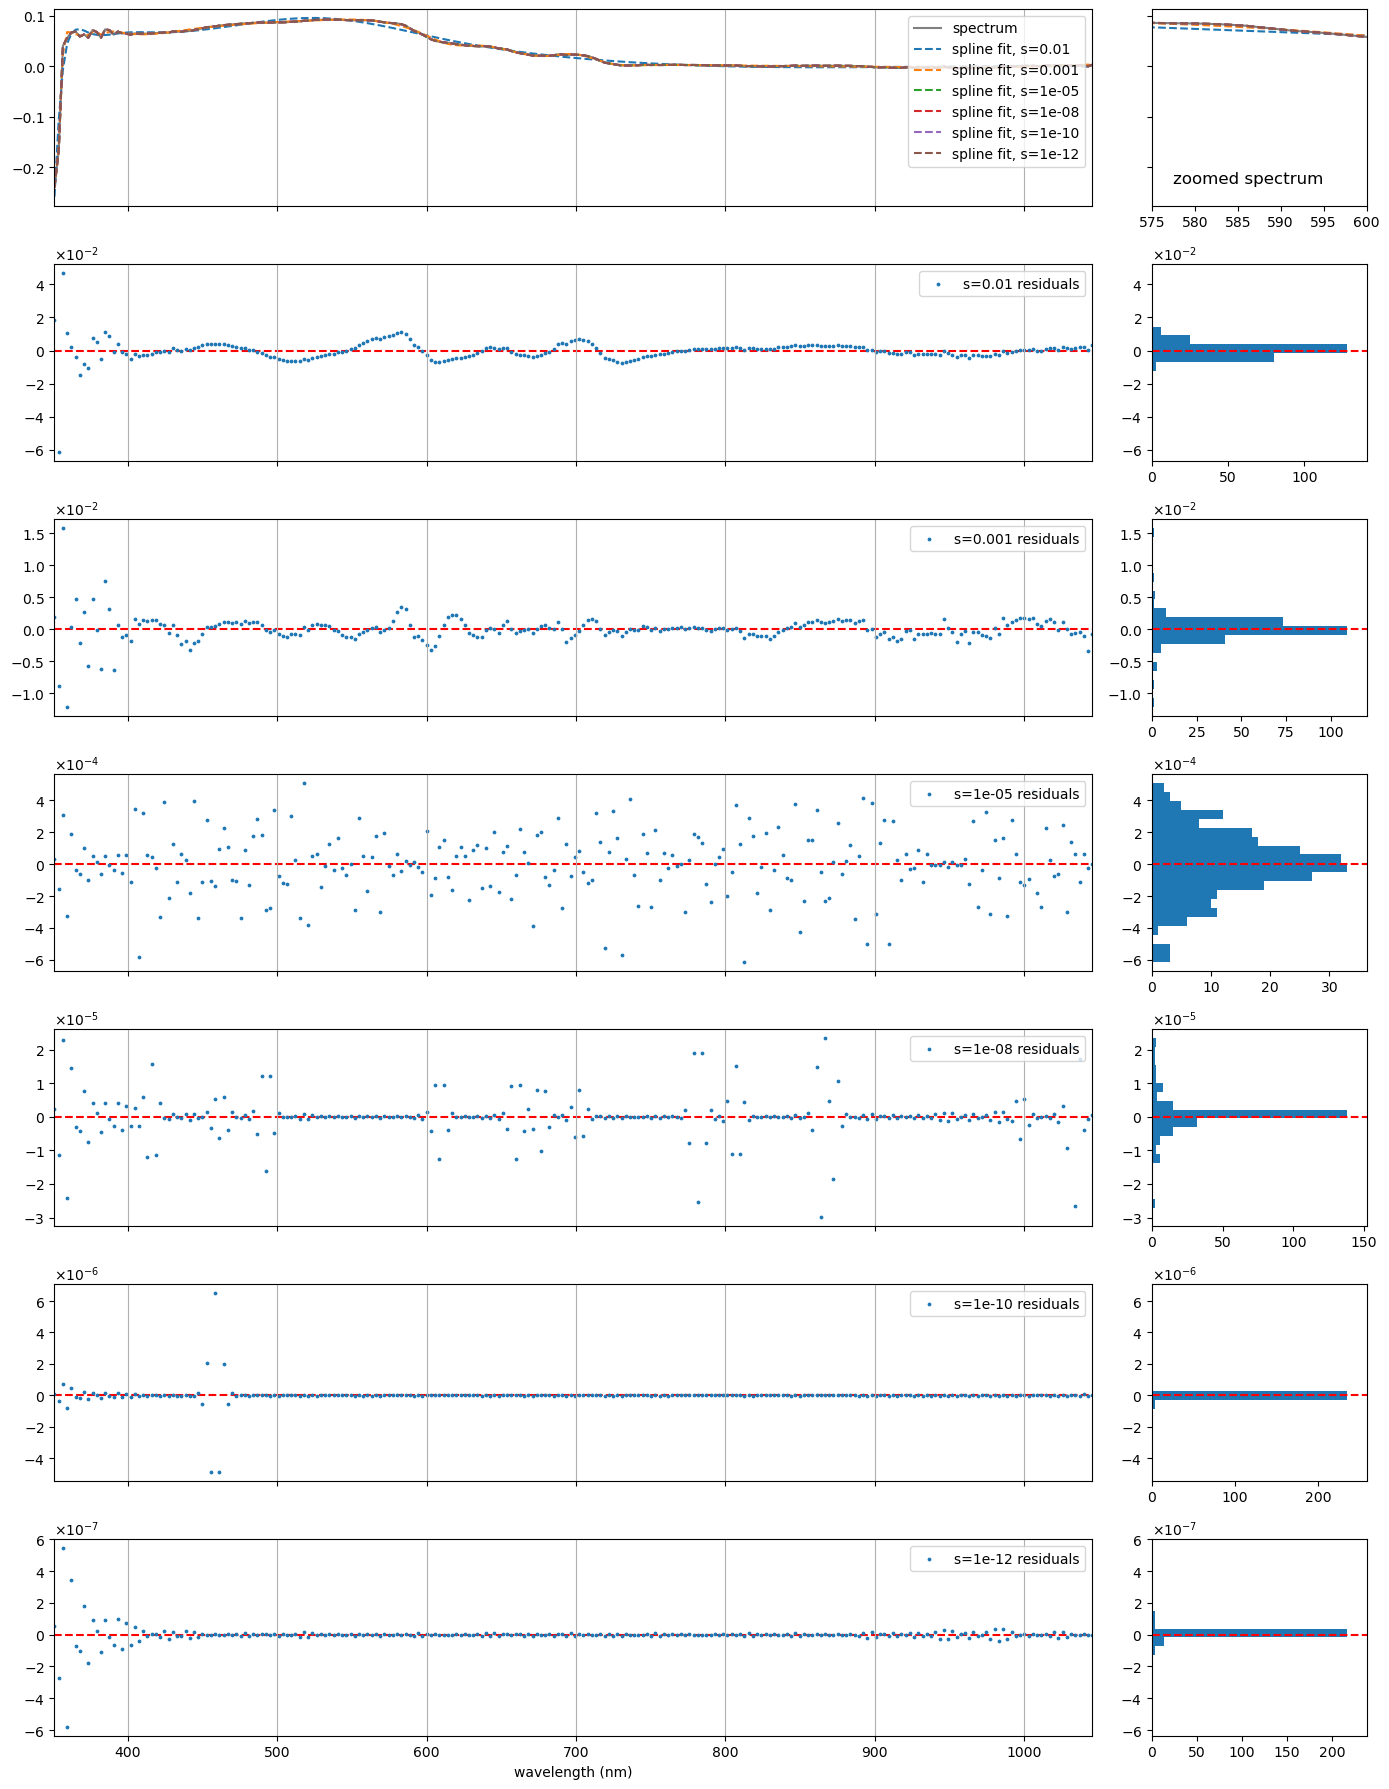

In [24]:
# plotting all wavelengths (uncropped spectra)
plotting.plot_spline_fits(smoothing_factors=smoothing_factors, spectrum=spectra_corrected.iloc[i], zoom_wvs=zoom_wvs)

## Fitting spectra

In [25]:
# # example of least-squares curve fit: a precursor to fitting via scipy.minimize
# i = 888
# plt.plot(prism_spectra.columns, prism_spectra.loc[i]);

# AOD_sub = AOP_model.loc[prism_spectra.columns]
# AOD_args = (AOD_sub.bb_m.values, AOD_sub.bb_c.values, AOD_sub.Kd_m.values, AOD_sub.Kd_c.values)

# # fitting curve with scalar Rb
# # function needs to be passed with lambda function since we need to pass additional arguments (AOD_args)
# p, cov = curve_fit(lambda x, bb, Kd, Rb, H: spectrum_utils.sub_surface_reflectance(x, bb, Kd, Rb, H, *AOD_args),
#                    prism_spectra.columns, # x values series (wavelengths)
#                    prism_spectra.loc[i],  # y values (example spectrum)
#                    p0=[0.1, 0.1, 0, 0],    # initialisation values for bb, Kd, Rb, H
#                    # value bounds (from AOP model). Rb min bound 0 since reflectance necessarily positive:
#                    bounds=([0, 0.01688, 0, -1], [0.41123, 3.17231, np.inf, np.inf]))    
# plt.plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance(prism_spectra.columns, *p, *AOD_args), color='red')
# # calculate spectrum r2
# r2 = r2_score(prism_spectra.loc[i], spectrum_utils.sub_surface_reflectance(prism_spectra.columns, *p, *AOD_args))
# plt.title(f"r$^2$: {r2:.5f}");

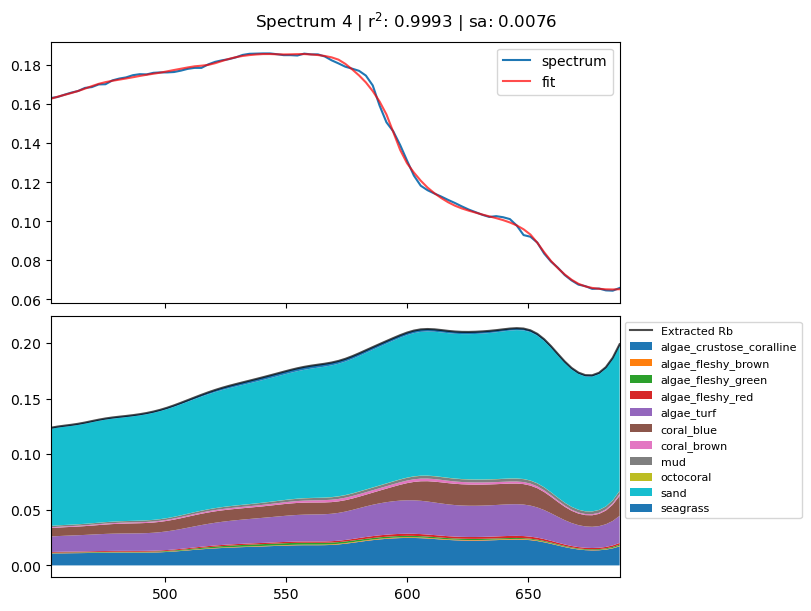

In [28]:
# minimise a single spectrum
i = 4

# load in endmember data
AOD_sub = AOP_model.loc[prism_spectra.columns]
AOD_args = (AOD_sub.bb_m.values, AOD_sub.bb_c.values, AOD_sub.Kd_m.values, AOD_sub.Kd_c.values)


def spectral_angle_objective_fn(x, obs, bb_m, bb_c, Kd_m, Kd_c, end_member_array):
    bb, K, H = x[:3]
    Rb_values = x[3:]
    Rb = spectrum_utils.Rb_endmember(end_member_array, *Rb_values)
    pred = spectrum_utils.sub_surface_reflectance(1, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)
    return spectrum_utils.spectral_angle(pred, obs)


end_member_bounds = (0, np.inf)
fit = minimize(
            spectrum_utils.r2_objective_fn,
            # spectrum_utils.spectral_angle_objective_fn,
            # initial parameter values
            x0=[0.1, 0.1, 0] + [0.0001] * len(end_member_array),
            # extra arguments passsed to the object function (and its derivatives)
            args=(prism_spectra.loc[i], # spectrum to fit (obs)
                  *AOD_args,    # backscatter and attenuation coefficients (bb_m, bb_c, Kd_m, Kd_c)
                  end_member_array  # typical end-member spectra
                  ),
            # constrain values
            bounds=[(0, 0.41123), (0.01688, 3.17231), (0, 50)] + [end_member_bounds] * len(end_member_array)) # may not always want to constrain this (e.g. for PCs)


fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8,6))

bb, K, H = fit.x[:3]
axs[0].plot(prism_spectra.columns, prism_spectra.loc[i], label='spectrum')
axs[0].plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, bb, K, H, AOD_args, *fit.x[3:]), color='red', alpha=0.7, label='fit')
axs[0].legend()

axs[1].plot(prism_spectra.columns, spectrum_utils.Rb_endmember(end_member_array, *fit.x[-11:]), color='k', alpha=0.7, label='Extracted Rb')
axs[1].set_xlim(prism_spectra.columns.min(), prism_spectra.columns.max())

endmember_contribution = end_member_array * fit.x[-11:].reshape(-1,1)
y = np.zeros(endmember_contribution.shape[1])
for label, endmember in zip(end_members, endmember_contribution):
    ynew = y + endmember
    axs[1].fill_between(prism_spectra.columns, y, ynew, label=label, lw=0)
    y = ynew
    
r2 = r2_score(prism_spectra.loc[i], spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, bb, K, H, AOD_args, *fit.x[3:]))
axs[1].legend(bbox_to_anchor=(1,1), fontsize=8)
# plt.suptitle(f"r$^2$: {fits.loc[i].r2:.4f} (spectrum {i})");
plt.suptitle(f"Spectrum {i} | r$^2$: {r2:.4f} | sa: {spectrum_utils.spectral_angle(prism_spectra.loc[i], spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, bb, K, H, AOD_args, *fit.x[3:])):.4f}");

In [29]:

rerun = True

# Create a partial function with additional arguments fixed
# partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.r2_objective_fn, prism_spectra=prism_spectra, AOD_args=AOD_args, end_member_array=end_member_array)
partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.spectral_angle_objective_fn, prism_spectra=prism_spectra, AOD_args=AOD_args, end_member_array=end_member_array, Rb_init=0.0001)

# if rerun fitting process
if rerun:
    with mp.Pool() as pool:
        result = list(tqdm(pool.imap(partial_wrapper, prism_spectra.index), total=len(prism_spectra.index)))

    fits = pd.DataFrame(result, index=prism_spectra.index, columns=['bb', 'K', 'H'] + list(cats))
    # fits.to_csv('tmp/fits_avg_endmembers_new.csv')
# else load in values from tempfile
else:
    fits = pd.read_csv('tmp/fits_avg_endmembers_new.csv', index_col=0)
    # fits = pd.read_csv('tmp/fits_avg_endmembers_og.csv', index_col=0) # original
    
fits.head()

  0%|          | 0/1938 [00:00<?, ?it/s]

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:169: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / (norm_a * norm_b)
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:169: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / (norm_a * norm_b)
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:169: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / (norm_a * norm_b)
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:169: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / (norm_a * norm_b)
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofC

  0%|          | 0/1938 [00:00<?, ?it/s]

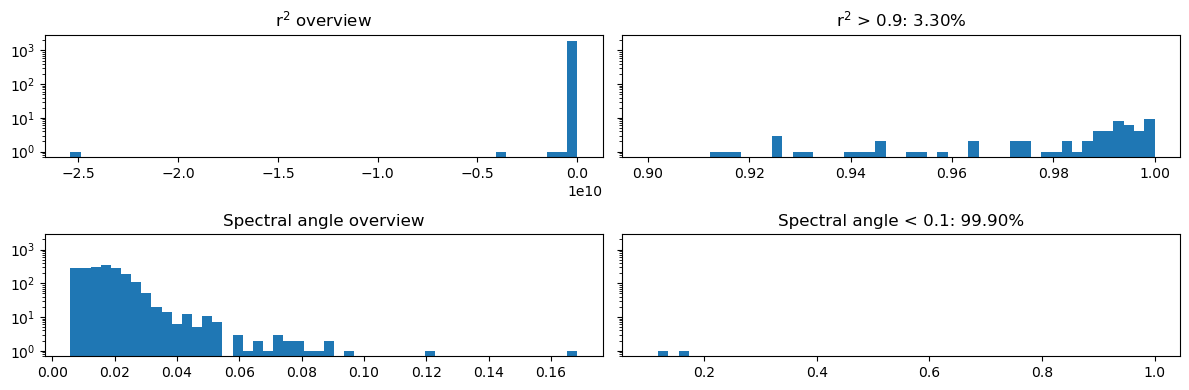

In [608]:
# assign nans to r2 column
fits['r2'] = np.nan
fits['spectral_angle'] = np.nan

for i, row in tqdm(fits.iterrows(), total=len(fits)):
    bb_m, bb_c, Kd_m, Kd_c = AOD_args
    bb, K, H = row.values[:3]
    pred = spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, bb, K, H, AOD_args, *row.values[3:-2])
    fits.loc[i, 'r2'] = r2_score(prism_spectra.loc[i], pred)
    fits.loc[i, 'spectral_angle'] = spectrum_utils.spectral_angle(prism_spectra.loc[i], pred)
    
fig, ax = plt.subplots(2, 2, figsize=(12, 4), sharey=True)
ax[0,0].hist(fits.r2, bins=50);
ax[0,0].set_yscale('log')
ax[0,0].set_title("r$^2$ overview")

min_r2 = 0.9
ax[0,1].hist(fits.r2, bins=np.linspace(min_r2, 1, 50));
ax[0,1].set_title(f"r$^2$ > 0.9: {100*sum(fits.r2 > min_r2)/len(fits):.2f}%");

ax[1,0].hist(fits.spectral_angle, bins=50);
ax[1,0].set_yscale('log')
ax[1,0].set_title("Spectral angle overview")

min_sa = 0.1
ax[1,1].hist(fits.spectral_angle, bins=np.linspace(min_sa, 1, 50));
ax[1,1].set_title(f"Spectral angle < 0.1: {100*sum(fits.spectral_angle < min_sa)/len(fits):.2f}%");
plt.tight_layout()


In [610]:
fit

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.0075672864417883606
        x: [ 2.329e-01  4.438e-01 ...  1.795e-01  9.898e-02]
      nit: 82
      jac: [ 2.934e-06 -8.803e-06 ... -8.803e-06 -5.869e-06]
     nfev: 1590
     njev: 106
 hess_inv: <14x14 LbfgsInvHessProduct with dtype=float64>

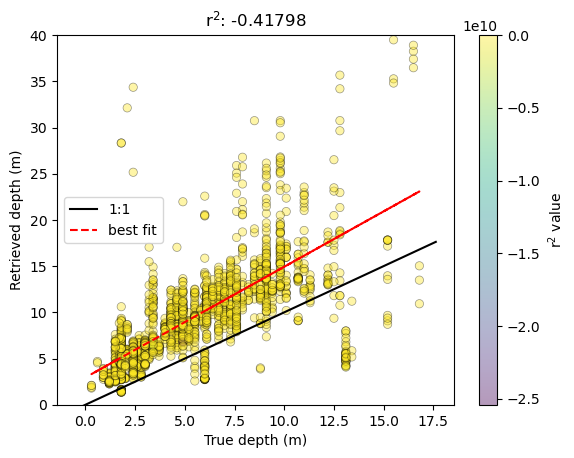

In [611]:
fig, ax = plt.subplots()
ma = ax.scatter(validation_data.Depth, fits.H, alpha=0.4, c=fits.r2, edgecolor='k', lw=0.5)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='k', label='1:1')

# calculate fits
p = np.polyfit(validation_data.Depth, fits.H, 1)
pred = np.polyval(p, validation_data.Depth)
r2 = r2_score(validation_data.Depth, pred)
ax.plot(validation_data.Depth, pred, color='r', ls='--', label="best fit")
# formatting
ax.set_title(f"r$^2$: {r2:.5f}")
ax.set_xlabel("True depth (m)")
ax.set_ylabel("Retrieved depth (m)")
ax.set_ylim(0,40)
fig.colorbar(ma, label="r$^2$ value")
ax.legend()

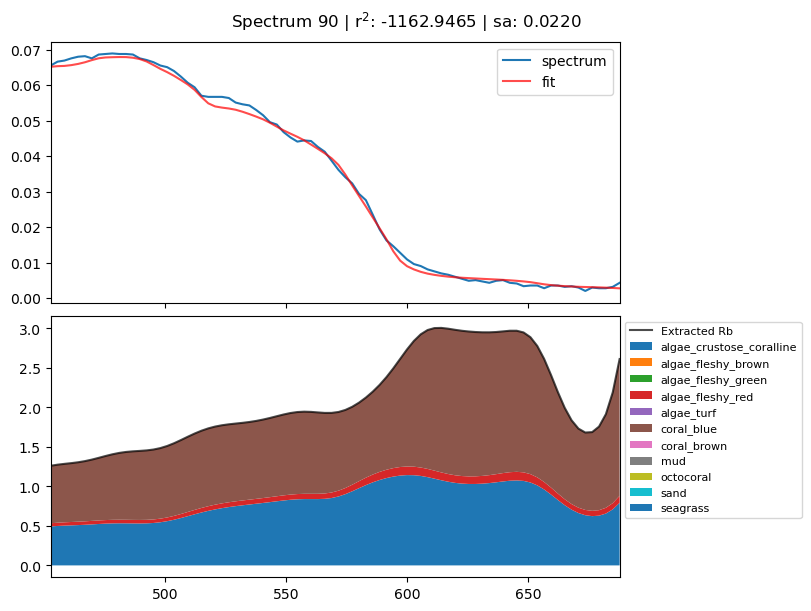

In [733]:
i = 90

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8,6))

axs[0].plot(prism_spectra.columns, prism_spectra.loc[i], label='spectrum');

bb, K, H = fits.loc[i].values[:3]
axs[0].plot(prism_spectra.columns, 0.045*spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, bb, K, H, AOD_args, *fits.loc[i].values[3:-2]), color='red', alpha=0.7, label='fit')
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(prism_spectra.columns, spectrum_utils.Rb_endmember(end_member_array, *fits.loc[i].values[-13:-2]), color='k', alpha=0.7, label='Extracted Rb')
axs[1].set_xlim(prism_spectra.columns.min(), prism_spectra.columns.max())

endmember_contribution = end_member_array * fits.loc[i].values[-13:-2].reshape(-1,1)
y = np.zeros(endmember_contribution.shape[1])
for label, endmember in zip(cats, endmember_contribution):
    ynew = y + endmember
    axs[1].fill_between(prism_spectra.columns, y, ynew, label=label, lw=0)
    y = ynew
    
axs[1].legend(bbox_to_anchor=(1,1), fontsize=8)
r2 = r2_score(prism_spectra.loc[i], spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, bb, K, H, AOD_args, *fits.loc[i].values[3:-2]))
sa = spectrum_utils.spectral_angle(prism_spectra.loc[i], spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, bb, K, H, AOD_args, *fits.loc[i].values[3:-2]))
plt.suptitle(f"Spectrum {i} | r$^2$: {r2:.4f} | sa: {sa:.4f}");

## With normalisation

In [641]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()

prism_spectra_minmax_norm = pd.DataFrame(minmax_scaler.fit_transform(prism_spectra), columns=prism_spectra.columns, index=prism_spectra.index)


452.642775  455.475056  458.307394  461.139788  463.972238  466.804744  \
0       0.625350    0.621151    0.621339    0.616468    0.616359    0.611071   
1       0.623214    0.621977    0.616893    0.614448    0.611131    0.607294   
2       0.578597    0.575008    0.572923    0.570298    0.565175    0.561635   
3       0.629883    0.630873    0.623316    0.622157    0.620113    0.611593   
4       0.639219    0.630374    0.629473    0.623540    0.621475    0.618818   
...          ...         ...         ...         ...         ...         ...   
1933    0.220656    0.218141    0.222774    0.217140    0.215495    0.212664   
1934    0.241609    0.239375    0.239710    0.239132    0.238535    0.236677   
1935    0.284145    0.283696    0.283508    0.284155    0.284874    0.282977   
1936    0.246398    0.248085    0.248977    0.243703    0.246906    0.243665   
1937    0.246735    0.245742    0.247983    0.246629    0.245939    0.244611   

      469.637306  472.469925  475.302600  478.135331  ...  662.383497  \
0       0.605612    0.606133    0.603493    0.595486  ...    0.440272   
1       0.609059    0.603791    0.604241    0.594488  ...    0.445028   
2       0.560612    0.559466    0.556207    0.550520  ...    0.415697   
3       0.610596    0.611047    0.608375    0.600316  ...    0.438725   
4       0.614142    0.613665    0.608796    0.607192  ...    0.456977   
...          ...         ...         ...         ...  ...         ...   
1933    0.214005    0.211500    0.212757    0.207693  ...    0.088989   
1934    0.237031    0.239310    0.236648    0.234401  ...    0.089321   
1935    0.285678    0.286765    0.284467    0.282796  ...    0.089423   
1936    0.243293    0.245495    0.244030    0.241085  ...    0.090354   
1937    0.244850    0.245183    0.243720    0.239566  ...    0.089831   

      665.219940  668.056439  670.892995  673.729607  676.566275  679.402999  \
0       0.437004    0.433735    0.436573    0.431246    0.430110    0.425292   
1       0.438484    0.439748    0.433550    0.430030    0.430779    0.429779   
2       0.406130    0.408207    0.401208    0.398897    0.399246    0.395239   
3       0.435394    0.432071    0.428442    0.429509    0.425494    0.421609   
4       0.449219    0.447257    0.442163    0.444419    0.439691    0.441560   
...          ...         ...         ...         ...         ...         ...   
1933    0.090584    0.096155    0.096689    0.098198    0.096954    0.099498   
1934    0.093054    0.097594    0.100370    0.099686    0.097320    0.098723   
1935    0.094223    0.099879    0.100479    0.097544    0.099711    0.097695   
1936    0.093054    0.096505    0.098154    0.097433    0.099598    0.098723   
1937    0.091452    0.098132    0.095374    0.099116    0.099022    0.097004   

      682.239779  685.076616  687.913509  
0       0.423790    0.419314    0.419439  
1       0.424461    0.422827    0.419159  
2       0.396670    0.388465    0.394508  
3       0.420110    0.420404    0.416742  
4       0.436258    0.429834    0.430845  
...          ...         ...         ...  
1933    0.101650    0.090818    0.092684  
1934    0.098599    0.092319    0.090785  
1935    0.098711    0.092431    0.093159  
1936    0.098599    0.092319    0.094177  
1937    0.099161    0.091744    0.091344  

[1938 rows x 84 columns]

In [719]:
rerun = True

# Create a partial function with additional arguments fixed

norm_endmember_array = minmax_scaler.fit_transform(end_member_array)

# partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.r2_objective_fn, prism_spectra=prism_spectra, AOD_args=AOD_args, end_member_array=end_member_array)
partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.spectral_angle_objective_fn, prism_spectra=prism_spectra_minmax_norm, AOD_args=AOD_args, end_member_array=norm_endmember_array, Rb_init=0.0001)

# if rerun fitting process
if rerun:
    with mp.Pool() as pool:
        minmax_result = list(tqdm(pool.imap(partial_wrapper, prism_spectra.index), total=len(prism_spectra.index)))

    minmax_fits = pd.DataFrame(result, index=prism_spectra.index, columns=['bb', 'K', 'H'] + list(cats))
    # minmax_fits.to_csv('tmp/minmax_fits_avg_endmembers_new.csv')
# else load in values from tempfile
else:
    minmax_fits = pd.read_csv('tmp/minmax_fits_avg_endmembers_new.csv', index_col=0)
    # minmax_fits = pd.read_csv('tmp/minmax_fits_avg_endmembers_og.csv', index_col=0) # original
    
minmax_fits.head()

  0%|          | 0/1938 [00:00<?, ?it/s]

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:124: RuntimeWarning:

invalid value encountered in scalar divide

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:124: RuntimeWarning:

invalid value encountered in scalar divide

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:124: RuntimeWarning:

invalid value encountered in scalar divide

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:124: RuntimeWarning:

invalid value encountered in scalar divide

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:124: RuntimeWarning:

invalid value encountered in scalar divide

/Users/rt582/Library/CloudStorage/OneDri

bb         K         H  algae_crustose_coralline  algae_fleshy_brown  \
0  0.255859  0.455763  3.254309                  0.419229                 0.0   
1  0.257077  0.452534  3.234678                  0.455527                 0.0   
2  0.409518  0.465366  3.331409                  0.805437                 0.0   
3  0.212599  0.477943  3.351257                  0.363610                 0.0   
4  0.232903  0.443817  3.171933                  0.385500                 0.0   

   algae_fleshy_green  algae_fleshy_red  algae_turf  coral_blue  coral_brown  \
0                 0.0          0.248995         0.0    0.213427          0.0   
1                 0.0          0.106761         0.0    0.211501          0.0   
2                 0.0          0.063238         0.0    0.409733          0.0   
3                 0.0          0.000000         0.0    0.211888          0.0   
4                 0.0          0.104665         0.0    0.170377          0.0   

        mud  octocoral      sand  seagrass  
0  0.000000   0.009881  0.189283  0.094251  
1  0.000000   0.043082  0.165188  0.104339  
2  0.000000   0.122519  0.207476  0.140833  
3  0.000058   0.078918  0.120862  0.071758  
4  0.000000   0.029311  0.179514  0.098984

  0%|          | 0/1938 [00:00<?, ?it/s]

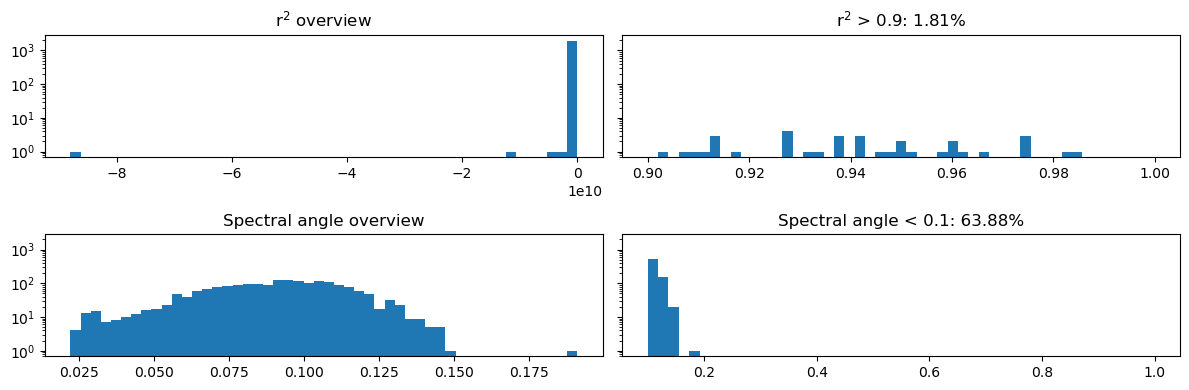

In [721]:
# assign nans to r2 column
minmax_fits['r2'] = np.nan
minmax_fits['spectral_angle'] = np.nan

for i, row in tqdm(minmax_fits.iterrows(), total=len(minmax_fits)):
    bb_m, bb_c, Kd_m, Kd_c = AOD_args
    bb, K, H = row.values[:3]
    pred = spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, norm_endmember_array, bb, K, H, AOD_args, *row.values[3:-2])
    minmax_fits.loc[i, 'r2'] = r2_score(prism_spectra.loc[i], pred)
    minmax_fits.loc[i, 'spectral_angle'] = spectrum_utils.spectral_angle(prism_spectra.loc[i], pred)
    
fig, ax = plt.subplots(2, 2, figsize=(12, 4), sharey=True)
ax[0,0].hist(minmax_fits.r2, bins=50);
ax[0,0].set_yscale('log')
ax[0,0].set_title("r$^2$ overview")

min_r2 = 0.9
ax[0,1].hist(minmax_fits.r2, bins=np.linspace(min_r2, 1, 50));
ax[0,1].set_title(f"r$^2$ > 0.9: {100*sum(minmax_fits.r2 > min_r2)/len(minmax_fits):.2f}%");

ax[1,0].hist(minmax_fits.spectral_angle, bins=50);
ax[1,0].set_yscale('log')
ax[1,0].set_title("Spectral angle overview")

min_sa = 0.1
ax[1,1].hist(minmax_fits.spectral_angle, bins=np.linspace(min_sa, 1, 50));
ax[1,1].set_title(f"Spectral angle < 0.1: {100*sum(minmax_fits.spectral_angle < min_sa)/len(minmax_fits):.2f}%");
plt.tight_layout()


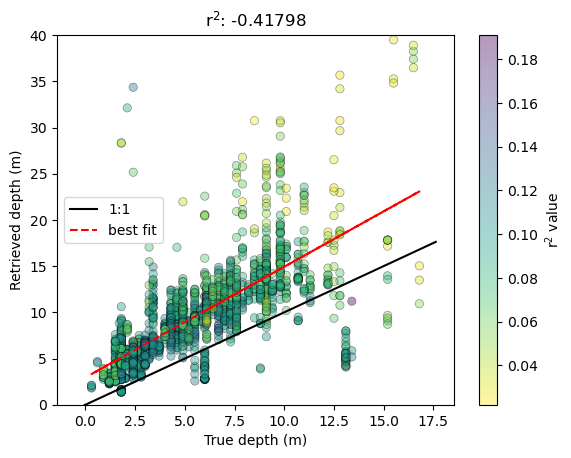

In [722]:
fig, ax = plt.subplots()
ma = ax.scatter(validation_data.Depth, minmax_fits.H, alpha=0.4, c=minmax_fits.spectral_angle, edgecolor='k', cmap="viridis_r", lw=0.5)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='k', label='1:1')

# calculate minmax_fits
p = np.polyfit(validation_data.Depth, minmax_fits.H, 1)
pred = np.polyval(p, validation_data.Depth)
r2 = r2_score(validation_data.Depth, pred)
ax.plot(validation_data.Depth, pred, color='r', ls='--', label="best fit")
# formatting
ax.set_title(f"r$^2$: {r2:.5f}")
ax.set_xlabel("True depth (m)")
ax.set_ylabel("Retrieved depth (m)")
ax.set_ylim(0,40)
fig.colorbar(ma, label="r$^2$ value")
ax.legend()

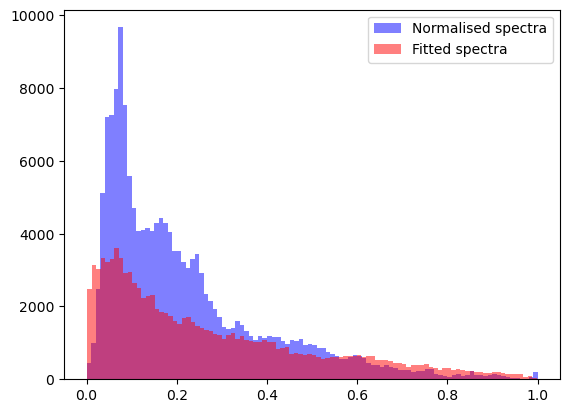

In [723]:
# create dataframe of spectra from minmax_result (apply spectrum_utils.sub_surface_reflectance_Rb() to each row)
minmax_spectra = pd.DataFrame([spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, norm_endmember_array, *row.values[:3], AOD_args, *row.values[3:-2]) for i, row in minmax_fits.iterrows()], index=minmax_fits.index, columns=prism_spectra.columns)
# plot histogram of values of prism_spectra_minmax_norm and minmax_spectra
plt.hist(prism_spectra_minmax_norm.values.flatten(), bins=100, alpha=0.5, label="Normalised spectra", color="b");

minmax_spectra_clean = minmax_spectra[(minmax_spectra.values < 1).all(axis=1)]
# minmax_spectra_clean

plt.hist(minmax_spectra_clean.values.flatten(), bins=100, alpha=0.5, label="Fitted spectra", color="r");
plt.legend()

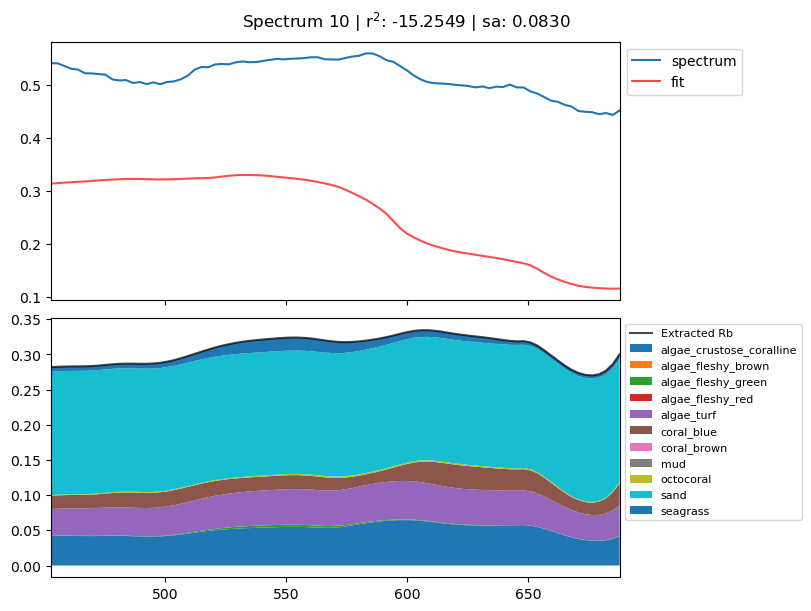

In [724]:
i = 10

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8,6))

axs[0].plot(prism_spectra_minmax_norm.columns, prism_spectra_minmax_norm.loc[i], label='spectrum');

bb, K, H = minmax_fits.loc[i].values[:3]
axs[0].plot(prism_spectra_minmax_norm.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra_minmax_norm.columns, norm_endmember_array, bb, K, H, AOD_args, *minmax_fits.loc[i].values[3:-2]), color='red', alpha=0.7, label='fit')
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(prism_spectra_minmax_norm.columns, spectrum_utils.Rb_endmember(norm_endmember_array, *minmax_fits.loc[i].values[-13:-2]), color='k', alpha=0.7, label='Extracted Rb')
axs[1].set_xlim(prism_spectra_minmax_norm.columns.min(), prism_spectra_minmax_norm.columns.max())

endmember_contribution = norm_endmember_array * minmax_fits.loc[i].values[-13:-2].reshape(-1,1)
y = np.zeros(endmember_contribution.shape[1])
for label, endmember in zip(cats, endmember_contribution):
    ynew = y + endmember
    axs[1].fill_between(prism_spectra_minmax_norm.columns, y, ynew, label=label, lw=0)
    y = ynew
    
axs[1].legend(bbox_to_anchor=(1,1), fontsize=8)
r2 = minmax_fits.loc[i].r2
sa = minmax_fits.loc[i].spectral_angle
plt.suptitle(f"Spectrum {i} | r$^2$: {r2:.4f} | sa: {sa:.4f}");

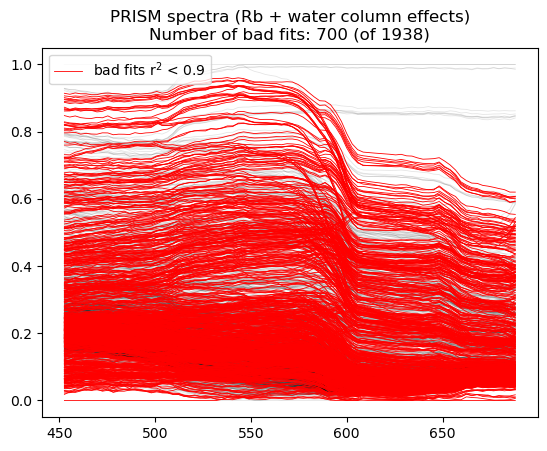

In [726]:
r2_threshold = 0.9
sa_threshold = 0.1

# bad_fits = minmax_fits[minmax_fits.r2 < threshold]
# good_fits = minmax_fits[minmax_fits.r2 >= threshold]
bad_fits = minmax_fits[minmax_fits.spectral_angle > sa_threshold]
good_fits = minmax_fits[minmax_fits.spectral_angle <= sa_threshold]

plt.title("")
plt.plot(prism_spectra_minmax_norm.columns, prism_spectra_minmax_norm.loc[bad_fits.index].values.T, color='red', lw=0.6)
plt.plot(prism_spectra_minmax_norm.columns, prism_spectra_minmax_norm.loc[good_fits.index].values.T, color='k', alpha=0.1, lw=0.6, zorder=-2);
plt.plot([], [], color="red", lw=0.6, label=f"bad fits r$^2$ < {threshold}")
plt.title(f'PRISM spectra (Rb + water column effects)\nNumber of bad fits: {bad_fits.shape[0]} (of {len(fits)})')
plt.legend();

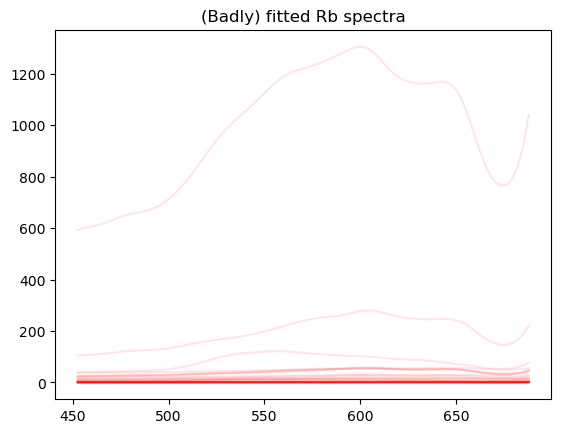

In [678]:
fig, ax = plt.subplots()
ax.set_title("(Badly) fitted Rb spectra")

for i, row in bad_fits.iterrows():
    Rb = spectrum_utils.Rb_endmember(end_member_array, *minmax_fits.loc[i, cats].values)
    ax.plot(prism_spectra.columns, Rb, color='r', alpha=0.1)

In [612]:
fits

bb         K          H  algae_crustose_coralline  \
0     0.255859  0.455763   3.254309                  0.419229   
1     0.257077  0.452534   3.234678                  0.455527   
2     0.409518  0.465366   3.331409                  0.805437   
3     0.212599  0.477943   3.351257                  0.363610   
4     0.232903  0.443817   3.171933                  0.385500   
...        ...       ...        ...                       ...   
1933  0.411230  0.263733  30.741581                  0.000044   
1934  0.094281  0.218607  19.033822                  0.000000   
1935  0.210737  0.210801  13.938687                  0.000000   
1936  0.343122  0.177659  13.479259                  0.153128   
1937  0.129555  0.198567  13.280377                  0.000000   

      algae_fleshy_brown  algae_fleshy_green  algae_fleshy_red  algae_turf  \
0               0.000000            0.000000          0.248995    0.000000   
1               0.000000            0.000000          0.106761    0.000000   
2               0.000000            0.000000          0.063238    0.000000   
3               0.000000            0.000000          0.000000    0.000000   
4               0.000000            0.000000          0.104665    0.000000   
...                  ...                 ...               ...         ...   
1933            0.003772            2.115634          1.988203    0.005218   
1934            0.000000            0.000000          3.998411    0.000000   
1935            0.000000            0.000000          9.492381    0.000000   
1936            0.000000            0.000000          2.249983    0.000125   
1937            0.000000            0.000000          0.300294    0.000000   

      coral_blue  coral_brown       mud  octocoral      sand  seagrass  \
0       0.213427     0.000000  0.000000   0.009881  0.189283  0.094251   
1       0.211501     0.000000  0.000000   0.043082  0.165188  0.104339   
2       0.409733     0.000000  0.000000   0.122519  0.207476  0.140833   
3       0.211888     0.000000  0.000058   0.078918  0.120862  0.071758   
4       0.170377     0.000000  0.000000   0.029311  0.179514  0.098984   
...          ...          ...       ...        ...       ...       ...   
1933    2.609143     0.045934  0.000000   0.063133  0.231033  1.471529   
1934    1.605468     0.000000  0.000000   0.237950  0.000000  0.000000   
1935    2.342786     0.000000  0.000000   1.166596  0.377831  0.000000   
1936    5.340223     0.231697  0.000000   1.043890  0.361847  0.000000   
1937    0.999282     0.000000  0.000000   0.000000  0.357413  0.000000   

              r2  spectral_angle  
0       0.974167        0.007156  
1       0.925139        0.007839  
2      -1.853354        0.007716  
3       0.151263        0.007428  
4       0.788194        0.007567  
...          ...             ...  
1933 -148.855989        0.022135  
1934   -1.816093        0.017767  
1935  -35.870853        0.017522  
1936 -128.171772        0.019044  
1937   -9.537780        0.019661  

[1938 rows x 16 columns]

In [616]:
# plot bb, K, H
fig = px.scatter_3d(fits, x='bb', y='K', z='H', color='spectral_angle', 
                    color_continuous_scale='viridis_r', opacity=0.5,
                    labels={'r2': 'R-squared'})

fig.show()

In [593]:
# plot bb, K, H
fig = px.scatter_3d(fits, x='bb', y='K', z='H', color='r2', 
                    color_continuous_scale='viridis', opacity=0.5,
                    labels={'r2': 'R-squared'})

fig.show()

In [27]:
# map between in-situ validation data and endmember categories
endmember_map = {
    'algae_crustose_coralline': ['algCCA'],
    'algae_fleshy_brown': ['algMacBrn'],
    'algae_fleshy_green': ['algMacGrn', 'algMacMix', 'algMacUnk', 'algCyano'],
    'algae_fleshy_red': ['algMacRed'],
    'algae_turf': ['algTurf'],
    'coral_blue': [],
    'coral_brown': ['crlCoral'],
    'mud': ['sedMud'],
    'octocoral': ['othOcto'],
    'sand': ['sedSand', 'crlBleach', 'sedLimest', 'sedRubble'],
    'seagrass': ['othSeagr'],
    # 'other': ['othClam', 'othInvert', 'othOther', 'othSponge', 'othUrchin']  # ignoring as max count is 3, and they don't fit categories well
}

# create empty dataframe with correct rows and column headers
validation_data_mapped = pd.DataFrame(index=validation_data.index, columns=endmember_map)

for end_member_type, validation_fields in endmember_map.items():
    # fill in validation data with sum of all fields in the category
    validation_data_mapped.loc[:, end_member_type] = validation_data.loc[:, validation_fields].sum(axis=1) 
# validation_data_mapped

# normalise validation data
validation_data_mapped_norm = validation_data_mapped.divide(validation_data_mapped.sum(axis=1), axis=0) # first sum along rows, then divide by row sum
# normalise fitted data
fits_norm = fits.loc[:, cats]
fits_norm = fits_norm.divide(fits_norm.sum(axis=1), axis=0)

In [28]:
# assign new 'coral' class as sum of blue and brown coral
validation_data_mapped_norm['coral'] = validation_data_mapped_norm[['coral_blue', 'coral_brown']].sum(axis=1)
fits_norm['coral'] = fits_norm[['coral_blue', 'coral_brown']].sum(axis=1)

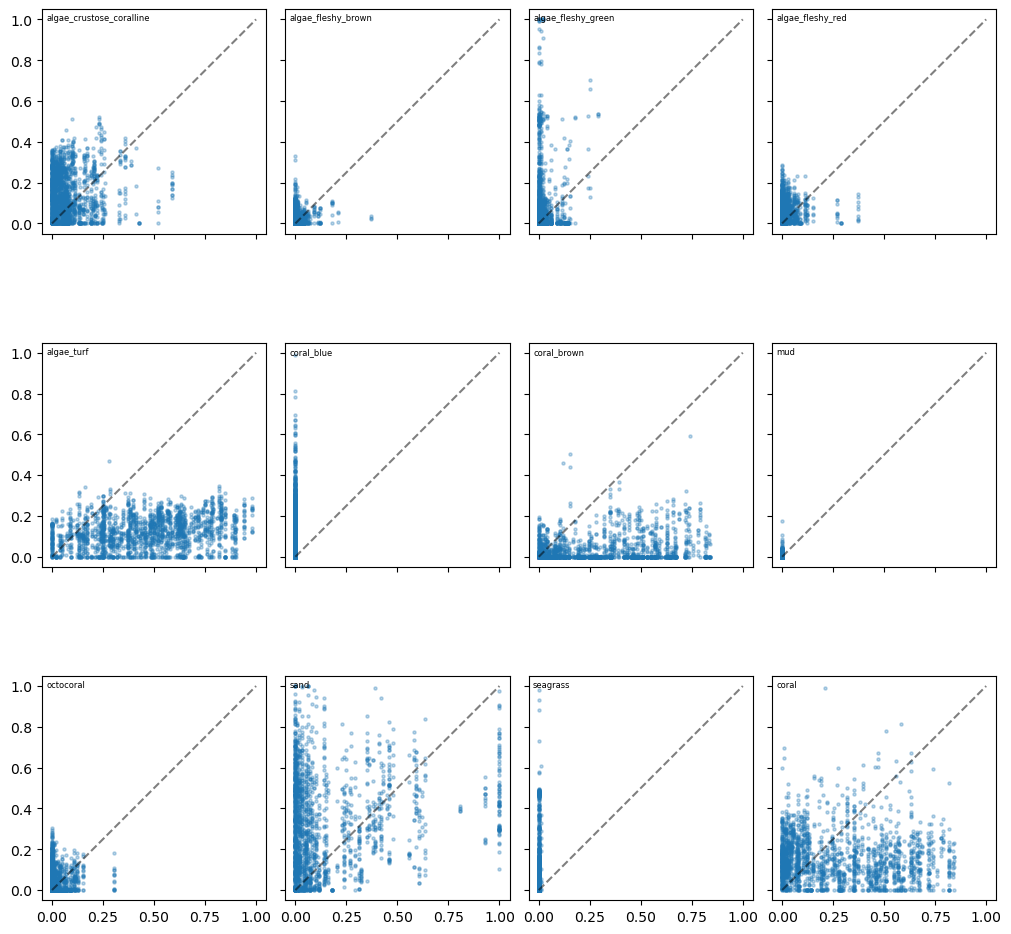

In [29]:
fig, axs = plt.subplots(3, 4, figsize=[10, 10], sharex=True, sharey=True, constrained_layout=True)

for endmember, ax in zip(fits_norm.columns, axs.flat):
    ax.scatter(validation_data_mapped_norm[endmember], fits_norm[endmember], s=5, alpha=0.3)
    ax.text(0.02, 0.98, endmember, ha='left', va='top', transform=ax.transAxes, fontsize=6)
    ax.axis('square')
    ax.plot([0,1], [0,1], color='k', ls='--', alpha=0.5)

In [30]:
new_cats = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass'],
    'CCA': ['algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}

pc_end_members = {}
pc1_end_members = {}

for cat in new_cats:
    ind = df.index.isin(new_cats[cat])
    pc_end_members[cat] = df.loc[ind].mean(axis=0)
    
    pca = PCA(1).fit(df.loc[ind])
    pc1_end_members[cat] = pca.components_[0]
    
pc_end_member_array = np.array([spectrum.values for spectrum in pc_end_members.values()])
pc1_end_member_array = np.array([spectrum for spectrum in pc1_end_members.values()])


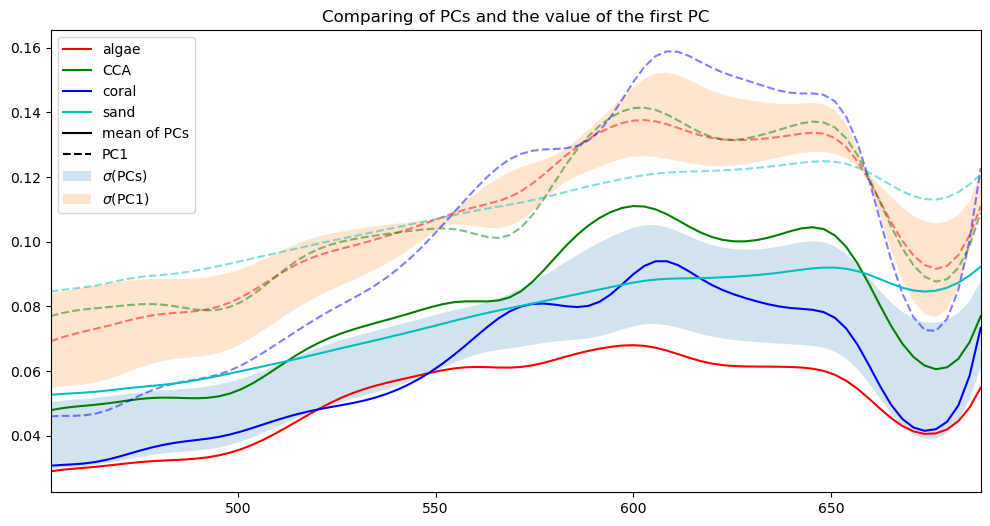

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
i = 1
cs = ['r', 'g', 'b', 'c']
for i_pca_end_member in range(pc_end_member_array.shape[0]):
    plt.plot(prism_spectra.columns, pc_end_member_array[i_pca_end_member], color=cs[i_pca_end_member], label=list(pc_end_members.keys())[i_pca_end_member])
    plt.plot(prism_spectra.columns, pc1_end_member_array[i_pca_end_member], ls='--', color=cs[i_pca_end_member], alpha=0.5)

plt.plot([],[], color='k', label='mean of PCs')
plt.plot([],[], color='k', ls='--', label='PC1')

# plot standard deviations
pc_endmember_std = pc_end_member_array.std(axis=0)
pc_endmember_mean = pc_end_member_array.mean(axis=0)
ax.fill_between(prism_spectra.columns, pc_endmember_mean - pc_endmember_std, pc_endmember_mean + pc_endmember_std, alpha=0.2, label="$\\sigma$(PCs)")
    
pc1_endmember_std = pc1_end_member_array.std(axis=0)
pc1_endmember_mean = pc1_end_member_array.mean(axis=0)
ax.fill_between(prism_spectra.columns, pc1_endmember_mean - pc1_endmember_std, pc1_endmember_mean + pc1_endmember_std, alpha=0.2, label="$\\sigma$(PC1)")

plt.title('Comparing of PCs and the value of the first PC')
plt.xlim(prism_spectra.columns.min(), prism_spectra.columns.max())
plt.legend();

In [32]:
# # not currently used
# pc_end_member_array_norm = pc_end_member_array - pc_end_member_array.min(axis=1)[:, None]
# pc_end_member_array_norm /= pc_end_member_array_norm.max(axis=1)[:, None]

In [33]:
partial_wrapper = partial(spectrum_utils._wrapper, prism_spectra=prism_spectra, AOD_args=AOD_args, end_member_array=pc_end_member_array)

# if rerun fitting process
if rerun:
    with mp.Pool() as pool:
        result = list(tqdm(pool.imap(partial_wrapper, prism_spectra.index), total=len(prism_spectra.index)))

  0%|          | 0/1938 [00:00<?, ?it/s]

In [34]:
pc_fits = pd.DataFrame(result, index=prism_spectra.index, columns=['bb', 'K', 'H'] + list(new_cats))
pc_fits.head()

bb         K         H     algae       CCA     coral      sand
0  0.381278  0.642047  3.485084  0.011607  0.777032  0.041827  1.024054
1  0.403988  0.642731  3.451881  0.260744  0.723884  0.134219  0.682730
2  0.315544  0.377005  3.387865  0.495202  0.351048  0.234613  0.755076
3  0.411230  0.637272  3.560667  0.327236  0.636779  0.281125  0.551100
4  0.363147  0.601745  3.365497  0.108785  0.536298  0.006082  1.385374

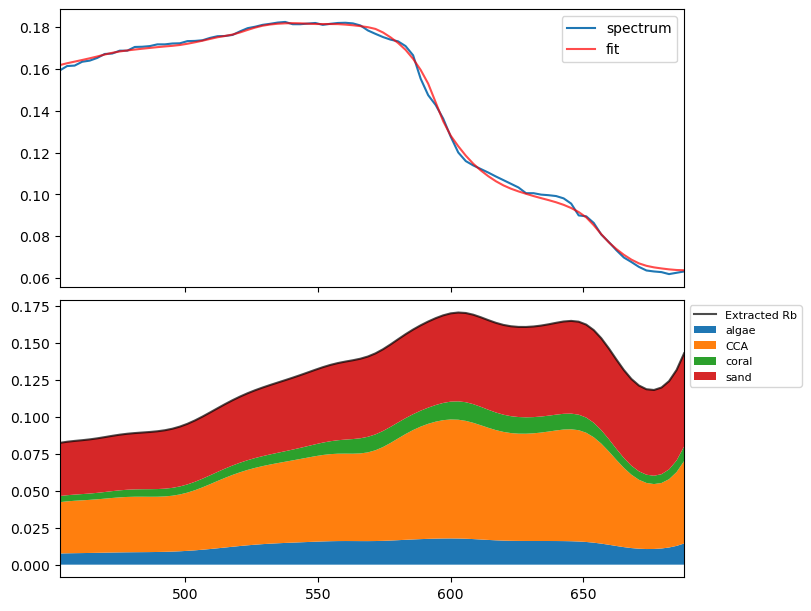

In [35]:
i = 1

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8,6))

axs[0].plot(prism_spectra.columns, prism_spectra.loc[i], label='spectrum');
bb, K, H = pc_fits.iloc[i,:][:3]    # TODO: is there a better way to make this generic? Probably via feeding [bb, K, H] as single argument (a list)
axs[0].plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, pc_end_member_array, bb, K, H, AOD_args, *pc_fits.iloc[i,:][3:]), color='red', alpha=0.7, label='fit')
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(prism_spectra.columns, spectrum_utils.Rb_endmember(pc_end_member_array, *pc_fits.iloc[i,:][-4:]), color='k', alpha=0.7, label='Extracted Rb')

axs[1].set_xlim(prism_spectra.columns.min(), prism_spectra.columns.max())

endmember_contribution = pc_end_member_array * pc_fits.iloc[i,:][-4:].values.reshape(-1,1)
y = np.zeros(endmember_contribution.shape[1])
for label, endmember in zip(pc_end_members, endmember_contribution):
    ynew = y + endmember
    axs[1].fill_between(prism_spectra.columns, y, ynew, label=label, lw=0)
    y = ynew
    
axs[1].legend(bbox_to_anchor=(1,1), fontsize=8)


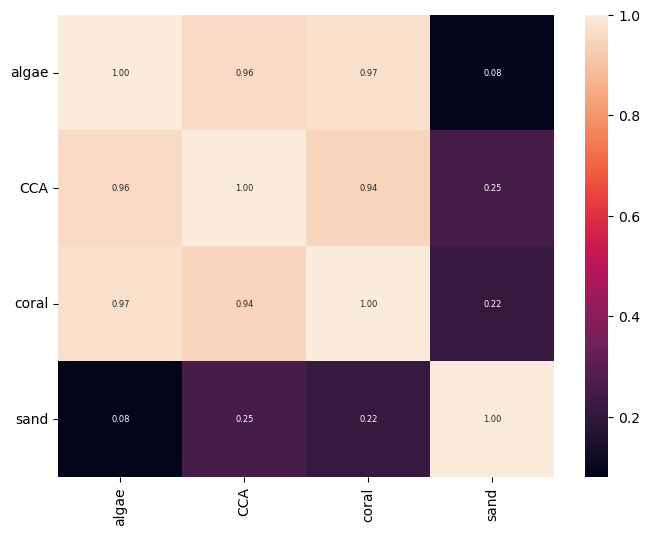

In [36]:
plt.figure(figsize=[8,6])
ax = sns.heatmap(np.corrcoef(pc_end_member_array[:, 44:]), annot=True, fmt='.2f', annot_kws={'fontsize':6})
ax.set_xticklabels(pc_end_members.keys(), rotation=90)
ax.set_yticklabels(pc_end_members.keys(), rotation=0);

## Simulation

TypeError: cannot unpack non-iterable int object

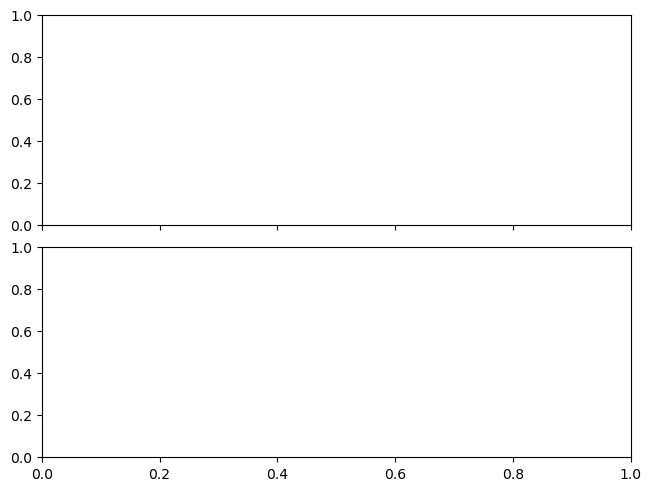

In [37]:
bb = 0.02
K = 0.2
H = 10

Rb0 = 0  # algae
Rb1 = 0  # CCA
Rb2 = 0.5  # coral
Rb3 = 0  # sand

def sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, bb_m, bb_c, Kd_m, Kd_c):
    Rb = spectrum_utils.Rb_endmember(Rb0, Rb1, Rb2, Rb3)
    return sub_surface_reflectance(wv, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True)

axs[0].plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, end_member_array, bb, K, H, 0, 0, 0, 0, *AOD_args), label='Rb=0')

cmap = plt.cm.viridis
cnorm = Normalize(vmin=0, vmax=6)

for Rb2 in np.linspace(0, 6, 10):

    sim = spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, bb, K, H, Rb0, Rb1, Rb2, Rb3, *AOD_args) 
    # sim += np.random.normal(0, 1e-4, len(prism_spectra.columns))

    axs[0].plot(prism_spectra.columns, sim, color=cmap(cnorm(Rb2)))

    axs[1].plot(prism_spectra.columns, spectrum_utils.Rb_endmember(Rb0, Rb1, Rb2, Rb3), color=cmap(cnorm(Rb2)))

ma = plt.cm.ScalarMappable(cmap=cmap, norm=cnorm)
fig.colorbar(ma, ax=axs[0])

In [ ]:
# investigating effect of adding noise
bb = 0.02
K = 0.2
H = 5

Rb0 = 0.1  # algae
Rb1 = 0.25  # CCA
Rb2 = 0.5  # coral
Rb3 = 0  # sand



sim = spectrum_utils.sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, *AOD_args) 
sim += np.random.normal(0, 1e-4, len(wv))

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True)

axs[0].plot(wv, spectrum_utils.sub_surface_reflectance_Rb(wv, bb, K, H, 0, 0, 0, 0, *AOD_args), label='Rb=0')

axs[0].plot(wv, sim)

axs[1].plot(wv, spectrum_utils.Rb_endmember(Rb0, Rb1, Rb2, Rb3), color='C1')

w = 1

fit = minimize(spectrum_utils.objective_fn_w,
            x0=[0.1, 0.1, 0] + [0] * 4,
            args=(sim, w, *AOD_args),
            bounds=[(0, 0.41123), (0.01688, 3.17231), (0, 50)] + [(0, np.inf)] * 4, tol=1e-9)

pred = spectrum_utils.sub_surface_reflectance_Rb(wv, *fit.x, *AOD_args)
axs[0].plot(wv, pred, color='C2', alpha=0.7, label='fit')

axs[1].plot(wv, spectrum_utils.Rb_endmember(*fit.x[-4:]), color='C2', alpha=0.7, label='Extracted Rb')

fit.x[-4:] / [Rb0, Rb1, Rb2, Rb3]

In [ ]:
plt.plot(wv,1 + 4 * stats.norm.pdf(wv, loc=570, scale=20))


In [ ]:
plt.plot(wv,1 + 4 * stats.norm.cdf(wv, loc=580, scale=20))

# Testing pipeline class

In [127]:
from reflectance import optimisation_pipeline
from reflectance import file_ops

configurations = file_ops.read_yaml('config.yaml')
configurations

{'global_configurations': {'spectra_fp': 'data/CORAL_validation_spectra.csv',
  'spectral_library_fp': 'reflectance/resources/spectral_library_clean_v3_PRISM_wavebands.csv'},
 'configurations': [{'aop_group_num': 1,
   'nir_wavelengths': [750, 1100],
   'sensor_range': [450, 690],
   'scaler_type': 'zscore'},
  {'aop_group_num': 2,
   'nir_wavelengths': [750, 1100],
   'sensor_range': [450, 690],
   'scaler_type': 'zscore'}],
 'endmember_map': {'algae_crustose_coralline': ['algCCA'],
  'algae_fleshy_brown': ['algMacBrn'],
  'algae_fleshy_green': ['algMacGrn', 'algMacMix', 'algMacUnk', 'algCyano'],
  'algae_fleshy_red': ['algMacRed'],
  'algae_turf': ['algTurf'],
  'coral_blue': [],
  'coral_brown': ['crlCoral'],
  'mud': ['sedMud'],
  'octocoral': ['othOcto'],
  'sand': ['sedSand', 'crlBleach', 'sedLimest', 'sedRubble'],
  'seagrass': ['othSeagr']}}

In [131]:
configurations["global_configurations"]["spectra_fp"]

'data/CORAL_validation_spectra.csv'

In [128]:

optimisation_pipeline.run_pipeline(configurations)

  0%|          | 0/3 [00:00<?, ?it/s]

TypeError: string indices must be integers, not 'str'

In [47]:
configurations[0]

{'aop_group_num': 1,
 'nir_wavelengths': [750, 1100],
 'sensor_range': [450, 690],
 'scaler_type': 'zscore'}

In [76]:
config = optimisation_pipeline.OptPipeConfig(configurations[0])

pipe = optimisation_pipeline.OptPipe(config)
pipe.run()
pipe.raw_spectra

350.718103   353.548360   356.378673   359.209042   362.039467   \
0         -0.0259      -0.0055       0.1102       0.1053       0.1182   
1         -0.0320      -0.0063       0.1043       0.1126       0.1259   
2         -0.0272      -0.0064       0.0974       0.1049       0.1222   
3         -0.0278      -0.0071       0.1067       0.1043       0.1169   
4         -0.0248      -0.0045       0.1115       0.1063       0.1315   
...           ...          ...          ...          ...          ...   
1933      -0.0371      -0.0155       0.0650       0.0749       0.0908   
1934      -0.0349      -0.0143       0.0692       0.0767       0.0876   
1935      -0.0294      -0.0101       0.0751       0.0759       0.0878   
1936      -0.0323      -0.0121       0.0709       0.0753       0.0888   
1937      -0.0335      -0.0100       0.0693       0.0768       0.0884   

      364.869949   367.700487   370.531081   373.361731   376.192438   ...  \
0          0.1235       0.1108       0.1159       0.1125       0.1205  ...   
1          0.1170       0.1131       0.1139       0.1081       0.1215  ...   
2          0.1165       0.1153       0.1160       0.1061       0.1123  ...   
3          0.1260       0.1157       0.1159       0.1106       0.1192  ...   
4          0.1218       0.1191       0.1207       0.1166       0.1197  ...   
...           ...          ...          ...          ...          ...  ...   
1933       0.0806       0.0766       0.0766       0.0721       0.0777  ...   
1934       0.0852       0.0783       0.0810       0.0745       0.0803  ...   
1935       0.0878       0.0820       0.0815       0.0755       0.0816  ...   
1936       0.0828       0.0802       0.0773       0.0734       0.0793  ...   
1937       0.0844       0.0805       0.0790       0.0727       0.0787  ...   

      1020.218215  1023.061744  1025.905330  1028.748971  1031.592670  \
0          0.0140       0.0140       0.0142       0.0141       0.0142   
1          0.0138       0.0138       0.0141       0.0150       0.0143   
2          0.0144       0.0142       0.0141       0.0148       0.0144   
3          0.0137       0.0141       0.0140       0.0144       0.0136   
4          0.0140       0.0149       0.0141       0.0144       0.0142   
...           ...          ...          ...          ...          ...   
1933       0.0304       0.0309       0.0312       0.0303       0.0312   
1934       0.0309       0.0312       0.0304       0.0306       0.0315   
1935       0.0301       0.0300       0.0301       0.0299       0.0302   
1936       0.0291       0.0288       0.0292       0.0291       0.0294   
1937       0.0293       0.0297       0.0293       0.0293       0.0294   

      1034.436424  1037.280234  1040.124101  1042.968024  1045.812003  
0          0.0135       0.0142       0.0145       0.0147       0.0148  
1          0.0150       0.0143       0.0162       0.0145       0.0142  
2          0.0138       0.0142       0.0137       0.0146       0.0143  
3          0.0146       0.0136       0.0155       0.0128       0.0142  
4          0.0151       0.0138       0.0159       0.0144       0.0153  
...           ...          ...          ...          ...          ...  
1933       0.0309       0.0314       0.0304       0.0314       0.0309  
1934       0.0312       0.0315       0.0312       0.0314       0.0306  
1935       0.0306       0.0303       0.0301       0.0299       0.0303  
1936       0.0297       0.0297       0.0297       0.0291       0.0299  
1937       0.0292       0.0296       0.0289       0.0299       0.0300  

[1938 rows x 246 columns]